# Part I: Supervised Classification

## Exclusions of Computationally Intensive Models From Part I

While the primary goal of this section is to explore a variety of traditional supervised classification models, some models are excluded due to the computational challenges posed by the EMNIST dataset's size and feature space. Below, we discuss the specific reasons for excluding these methods:

**Support Vector Machines (SVMs)**: SVMs aim to find a hyperplane that separates classes by maximizing the margin between them. For linear SVMs, training complexity is $O(n \cdot d)$, where $n$ is the number of samples and $d$ is the feature dimensionality. Non-linear SVMs, using kernels such as RBF or polynomial, involve computing a kernel matrix of size $n \times n$, with a complexity of $O(n^2 \cdot d)$. Solving the associated quadratic programming problem further increases the complexity to $O(n^3)$. These costs make kernel-based SVMs impractical for large datasets like EMNIST $(n = 240,000, d = 784)$ due to memory and time requirements. For inference, non-linear SVMs scale as $O(k \cdot d)$ per test point, where $k$ is the number of support vectors, which can also grow with $n$. Linear approximations (e.g., SGDClassifier) or kernel approximations (e.g., Random Fourier Features) are better suited for high-dimensional, large-scale datasets. In fact, we explore SGDClassifier in this part. 

**k-Nearest Neighbors (k-NN)**:
- k-NN computes pairwise distances between the query point and all training samples during inference, resulting in a prediction complexity of $O(n \cdot d)$ per test instance, where $d$ is the feature dimensionality. For a test set of size $m$, this means complexity of $O(m \cdot n \cdot d)$!
- The large size of $n$ and $d$ in the EMNIST dataset makes this approach computationally expensive in terms of memory and processing time.
- Approximate nearest neighbor methods, such as ***FAISS*** or ***Annoy***, which mitigate these issues, will be explored in **Part II**, where we implement optimization techniques like feature selection and dimensionality reduction to make k-NN feasible.

### **Clustering Methods**
Clustering-based approaches, including Gaussian Mixture Models (GMMs) and other clustering algorithms, are excluded for the following reasons:
- **Gaussian Mixture Models (GMMs)**: GMMs rely on the Expectation-Maximization (EM) algorithm to estimate parameters, with a complexity of $O(n \cdot k \cdot d^2)$, where $k$ is the number of Gaussian components. For large datasets like EMNIST, this makes them computationally expensive, especially in high-dimensional spaces.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: DBSCAN identifies clusters based on density and requires a neighborhood query for each point. Using spatial indexes (e.g., k-d trees), the complexity is $O(n \cdot \log(n))$ under ideal conditions. However, high-dimensional datasets like EMNIST $(d = 784)$ suffer from the **curse of dimensionality**, where spatial indexes degrade. This can increase the complexity to $O(n^2 \cdot d)$ in the worst case, as neighborhood queries effectively become linear scans. Increasing the neighborhood radius $\epsilon$ can further exacerbate this issue by dramatically increasing the number of neighbors per point, resulting in higher memory usage and computation time. These challenges make DBSCAN impractical for EMNIST without preprocessing techniques such as dimensionality reduction or approximate nearest neighbor methods.

- **Hierarchical Clustering**: This method has a complexity of $O(n^2 \log n)$, primarily due to the pairwise distance calculations required to form a hierarchy. This becomes impractical for datasets with tens of thousands of samples.
- **Spectral Clustering**: With a complexity of $O(n^3)$, spectral clustering involves eigenvector decompositions that are infeasible for large datasets without significant approximations.
  
While clustering methods can provide unique insights, their scalability issues make them unsuitable for direct application to the EMNIST dataset. Techniques to address these challenges, such as dimensionality reduction and stochastic approximations, are discussed in **Part II**.

### Looking Ahead: Optimizing Resource-Intensive Models
The models excluded in this part—k-NN and clustering methods in particular—are not permanently dismissed but deferred for more focused exploration in **Part II**. That section will introduce optimization techniques like feature selection, dimensionality reduction, and approximate algorithms to overcome computational barriers, with k-NN serving as the primary example. These strategies are broadly applicable to other computationally intensive models.


# Chapter 2

## 2.1. Helper Functionality for Baselining

As discussed earlier, our primary focus will be on binary classification for the digit 8. In Chapter 6, we will generalize our approach to address multiclass classification where we handle all digits from 0 to 9 together.

To prepare for the binary classification problem, we need to further preprocess the training and test labels. The following code generates two boolean arrays where each element is `True` if the corresponding label equals 8, and `False` otherwise.

Digits' images in EMNIST are two dimensional $28 \times 28$ arrays. For the purpose of training models, we need to flatten both the training and the testing data so that a digit image is a 1-dimensional array with $784$ elements/features.

In [47]:
train_digits_flattened = train_digits_images.reshape(train_digits_images.shape[0], -1)
test_digits_flattened = test_digits_images.reshape(test_digits_images.shape[0], -1)

In [48]:
# apply mask to select the subset: to be called later: validation_X_train
validation_X_train = subset_X_train
validation_y = subset_y_train
validation_y_8 = (subset_y_train == 8)

# create the complementary subset mask: this shall be called train_data_mask
complement_mask = ~subset_mask

# apply the complementary mask to select the remaining samples
X_train = train_digits_flattened[complement_mask]
y_train = train_digits_labels[complement_mask]

y_train_8 = (y_train == 8)

In [49]:
import time

def train_model(model):
    """
    train a model on the first 4 folds of the provided K-Folds and return the trained model and training time.

    args:
    - model (estimator): Machine learning model to train.
    - X (ndarray): Feature data (default: train_digits_flattened).
    - y (ndarray): Target labels (default: train_digits_labels_8).
    - folds (list): List of tuples containing train and validation indices for each fold.

    returns:
    - trained_model (estimator): The trained model.
    - training_time (float): Time taken to train the model in seconds.
    """
    # record start time
    start_time = time.time()

    # train the model
    model.fit(X_train, y_train_8)

    # record end time
    end_time = time.time()

    # calculate training time
    training_time = end_time - start_time

    print(f"Training Time: {training_time:.2f} seconds")

    return model, training_time

## 2.2. Baseline Models

## 2.2.1. Logistic Regression

It is a commonly used baseline model for classification tasks. Below, we first specify some hyperparameters and then train a model based on them. Afterwards, we provide a detailed explanation of key hyperparameters and their effects with a particular focus on the computational advantages of the `saga` solver.

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
# specify the hyperparameters to train a model based on (optional) 
hyperparameters_logReg = {
    'C': 0.01,
    'l1_ratio': 0.6,
    'max_iter': 300,
    'penalty': 'elasticnet',
    'solver': 'saga'
}

In [55]:
lg = LogisticRegression(**hyperparameters_logReg, random_state=42)

In [ ]:
baseline_lg = train_model(lg)

### 2.2.1.1. Hyperparameters and Computational Cost

Logistic Regression is a foundational model in classification tasks, with hyperparameters that influence three critical aspects: controlling overfitting and bias, managing computational cost, and achieving sparsity for faster predictions and reduced storage volumn need for saving model weights . Below, we organize the hyperparameter discussions under these themes.

### 1. Overfitting vs. Bias Control

How can we ensure our model generalizes well without overfitting or underfitting the data? The hyperparameters in this category directly influence this balance.

#### **Inverse Regularization Strength (`C`)**
`C` is the inverse of the regularization strength (1/λ). Lower values of `C` (stronger regularization) penalize large coefficients which simplifying the model and reducing the risk of overfitting. This can result in underfitting if the penalty is too strong especially when the model cannot capture the data's complexity. Higher values of `C` reduce regularization. This allows the model to better fit the training data but it increases the risk of overfitting. This risk is higher particularly in noisy or high-dimensional datasets. An optimal `C` balances bias and variance.

#### **Tolerance for Stopping Criterion (`tol`)**
`tol` defines the threshold for stopping optimization. Lower `tol` values enforce stricter convergence criteria. As a result solutions would be more precise but they will take a longer runtime. This precision can be crucial for controlling overfitting, as stopping prematurely may result in a poorly tuned model. Conversely, higher `tol` values prioritize faster convergence, which may suffice for less complex datasets but could allow residual overfitting.

### 2. Computational Cost

Hyperparameter settings here affect the runtime and resource requirements for training.

#### **Solver (`solver`)**
The solver determines the optimization method used to minimize the loss function, directly impacting computational efficiency. Here’s a comparison of solvers:

- **`saga`**: Efficient for large datasets with a computational cost of $O(k \cdot (n + p))$, where $k$ is the number of iterations, $n$ is the number of samples, and $p$ is the number of features. It supports all penalties (`l1`, `l2`, `elasticnet`, and `none`) and processes one data point at a time. This makes it ideal for high-dimensional datasets like EMNIST.
- **`newton-cg`**: Uses Newton's method, which calculates second-order derivatives (Hessian matrices). While this provides precise convergence, it has a much higher computational cost of $O(n^3 + np)$ which makes it unsuitable for large datasets.

- **`lbfgs`**: A Quasi-Newton method that approximates the Hessian matrix that results in a balance between precision and efficiency. Its computational cost $O(n^2 \cdot p)$ makes it suitable for small-to-medium datasets.

- **`liblinear`**: Uses coordinate descent, which is efficient for small, dense datasets. Its cost is $O(k \cdot (n + p))$, but it does not support penalties like `elasticnet`.

- **`sag`**: Similar to `saga`, but only supports L2 regularization. It is efficient with large datasets but lacks `saga`’s flexibility for other penalties.

#### **Maximum Number of Iterations (`max_iter`)**
`max_iter` controls how many iterations the solver is allowed to perform. Higher values allow the solver more time to converge but increase runtime. Particularly for complex models or large datasets. Lower values reduce computational cost but may result in premature stopping and suboptimal solutions.

### 3. Sparcity: Faster Predictions and Efficient Model Storage

Hyperparameter settings here focus on producing lightweight models with fewer coefficients. This results in faster predictions and reduced memory needed for storing the model weights.

#### **Penalty and Elastic Net Mixing Ratio (`penalty` and `l1_ratio`)**
Regularization methods control sparsity, which directly impacts the model's size and speed:

- **L1 Regularization (Lasso)**: Encourages sparsity by setting some coefficients to zero effectively selecting a subset of features. This reduces memory usage and accelerates predictions. For EMNIST, where many pixels may contribute little to digit classification, L1 regularization helps ignore irrelevant features without sacrificing performance.

- **L2 Regularization (Ridge)**: Smoothly shrinks coefficients toward zero without setting them to zero, retaining all features. While it doesn’t promote sparsity, it ensures robustness against multicollinearity and noisy features.

- **Elastic Net Regularization**: Combines the effects of L1 and L2 regularization, controlled by the `l1_ratio`. Higher `l1_ratio` values promote sparsity by emphasizing L1 regularization, whereas lower values favor L2 regularization for smoother coefficient shrinkage. Elastic net strikes a balance which facilitates lightweight models that retain important features while ignoring irrelevant ones.

- **No Regularization (`penalty='none'`)**: Retains all features with no penalties, resulting in models with large coefficients. This risks overfitting and higher memory usage particularly with high-dimensional datasets like EMNIST.

We should note that while sparsity can lead to faster predictions and efficient storage, excessive sparsity may oversimplify the model. The challenge is to find the right balance to maintain predictive power while keeping the model lightweight.

## 2.2.2. Stochastic Dradient Descent with Hinge Loss (Linear SVM Classifier) 

In [25]:
from sklearn.linear_model import SGDClassifier

In [57]:
hyperparameters_sgd = {
    'penalty': 'l2',
    'alpha': 0.01,
    'tol': 1e-2,
    'max_iter': 300
}

In [58]:
sgd = SGDClassifier(random_state=42, **hyperparameters_sgd)

In [59]:
baseline_sgd = train_model(sgd)

Training Time: 31.06 seconds


### 2.2.2.1. Overview of Hyperparameters, Computational Cost, and Contrast against Logistic Regression

Both `SGDClassifier` and `LogisticRegression` are linear models widely used for classification tasks, but they differ in optimization methods, computational efficiency, and flexibility. Below, we contrast these models in key areas to understand their strengths, weaknesses, and suitability for datasets like EMNIST.

#### 1. Similarities Between SGDClassifier and Logistic Regression

Both models compute a decision boundary as a linear combination of input features, making them linear classifiers. They also support regularization techniques like L1, L2, and Elastic Net to enhance generalization and prevent overfitting. Another similarity is their reliance on feature scaling—both models require standardized input data for optimal performance. This ensures that coefficients are balanced and do not disproportionately prioritize features with larger magnitudes.

#### 2. Contrasting SGDClassifier With Logistic Regression

#### Optimization Strategy

The most significant difference lies in their optimization methods. Logistic Regression uses full-batch solvers like `saga`, `lbfgs`, or `newton-cg`, *which compute gradients over the entire dataset for each iteration*. This results in deterministic and precise optimization but can be computationally expensive, especially for large datasets like EMNIST. In contrast, SGDClassifier employs stochastic gradient descent, which updates model parameters incrementally using one sample (or a small batch) at a time. This stochastic approach introduces randomness but makes SGDClassifier far more efficient for large-scale datasets. While Logistic Regression’s solvers are ideal for small-to-medium datasets where precise convergence is crucial, SGDClassifier is better suited for high-dimensional or resource-intensive tasks.

#### Flexibility in Loss Functions

SGDClassifier provides greater flexibility by allowing different loss functions, such as `hinge` (for SVM), `log_loss` (logistic regression), or `squared_hinge`. This versatility enables the use of SGDClassifier for tasks beyond traditional logistic regression. Logistic Regression, on the other hand, is specialized and focuses exclusively on logistic loss, making it less flexible but more straightforward for pure classification problems.

#### Regularization

Both models support regularization to control overfitting, but the parameters differ. In Logistic Regression, regularization strength is controlled by `C`, the inverse of λ. Smaller `C` values apply stronger regularization, and larger values reduce it. In SGDClassifier, this is managed through `alpha`, which directly scales the regularization term. Additionally, SGDClassifier allows fine-tuning of Elastic Net penalties using the `l1_ratio` parameter. Logistic Regression lacks this level of granularity, especially when Elastic Net penalties are desired.

#### Convergence Behavior

Logistic Regression typically achieves deterministic convergence due to its full-batch approach, controlled by the `tol` parameter, making it more reliable for small datasets. SGDClassifier, being stochastic, has less predictable convergence and requires careful tuning of parameters like the learning rate (`eta0`) and number of iterations (`max_iter`). While SGD can converge faster for large datasets, it is prone to oscillations, particularly if the learning rate is not tuned correctly.

#### 3. Computational Cost and Storage Requirements

SGDClassifier is designed for scalability. Its per-iteration cost is $O(p)$, where $p$ is the number of features, making each update computationally inexpensive. However, due to its incremental nature, achieving convergence may require more iterations, especially for complex problems. Logistic Regression, depending on the solver, is computationally heavier as we already have discussed above. 

In terms of storage, SGDClassifier is more memory-efficient because it processes data incrementally. Logistic Regression, particularly with solvers like `newton-cg`, requires substantial memory for storing intermediate matrices, such as the Hessian. For large datasets, this difference can be critical.

#### Scenarios Favoring SGDClassifier
SGDClassifier is ideal for large datasets like EMNIST, where its stochastic updates scale efficiently and handle high-dimensional data well. It is also preferred when flexibility is needed, such as experimenting with loss functions or handling sparse matrices. However, its stochastic nature makes it dependent on careful hyperparameter tuning to avoid convergence issues.

#### Scenarios Favoring Logistic Regression
Logistic Regression does well on small-to-medium datasets where full-batch optimization is computationally feasible. It offers deterministic convergence which makes it more reliable for precise optimization tasks. Additionally, its simpler tuning process and better defaults make it a good choice for scenarios where ***interpretability*** and ***consistency*** are prioritized.

## 2.2.3. Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
hyperparameters_dTr = {
    'max_depth': 6,
    'min_samples_split': 3,
    'min_samples_leaf': 1,
    'max_features': None
}

In [61]:
dTr = DecisionTreeClassifier(**hyperparameters_dTr, random_state=42)

In [62]:
baseline_dTr = train_model(dTr)

Training Time: 18.61 seconds


### 2.2.3.1. Reviewing Hyperparameters and More

A decision tree is a non-parametric supervised learning algorithm used for both classification and regression tasks. It partitions the data space recursively to create decision boundaries. The following hyperparameters influence the tree structure, its complexity, and its computational cost.

#### 1. Tree Structure and Complexity

These hyperparameters control the size, depth, and granularity of splits, impacting the tree's ability to fit patterns and generalize to unseen data.

**Maximum Tree Depth (`max_depth`)**
The `max_depth` parameter limits how deep the tree can grow. Shallower trees focus on high-level splits, simplifying the model and reducing the risk of overfitting. This can be beneficial for datasets like EMNIST, where some pixel-level patterns dominate digit shapes. Deeper trees allow for more complex patterns to be captured but may overfit, especially in noisy data.

**Minimum Samples Per Split (`min_samples_split`)**
The `min_samples_split` parameter specifies the minimum number of samples required to split an internal node. For large datasets like EMNIST, increasing this parameter prevents overly specific splits based on noise or outliers. Lower values encourage more splits, which might improve accuracy but risk overfitting.

**Minimum Samples in a Leaf (`min_samples_leaf`)**
The `min_samples_leaf` parameter sets the minimum number of samples required to form a leaf node. A higher value results in larger, more generalized leaves, reducing overfitting at the cost of granularity. For EMNIST, this parameter can help balance the simplicity of the tree and its ability to capture important patterns.

**Maximum Features Considered (`max_features`)**
The `max_features` parameter controls the maximum number of features to consider when determining the best split at each node. For EMNIST, where the dataset is high-dimensional, reducing `max_features` introduces feature-level randomness that improves generalization. This aligns with the **random subspace method**, often used in ensemble methods.

#### 2. Computational Cost

The computational cost of training a single decision tree is primarily driven by the number of samples $n$, features $p$, and the depth $d$ of the tree. The complexity is approximately $O(n \cdot p \cdot \log(n))$. Note however that despite its simplicity, decision trees can become computationally expensive for very large datasets without careful tuning.

- **Sample and Feature Size Impact**: Larger datasets and higher feature dimensions increase the computational load.
- **Tree Depth Impact**: Deeper trees require more splits and comparisons, increasing the training cost.

## 2.2.4. Ensemble Methods

## 2.2.4.1. Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
hyperparameters_rf = {
    'max_depth': 6,
    'max_features': 'sqrt',
    'min_samples_leaf': 6,
    'min_samples_split': 8,
    'n_estimators': 50
}

In [64]:
rf = RandomForestClassifier(**hyperparameters_rf, random_state=42)

In [65]:
baseline_rf = train_model(rf)

Training Time: 22.89 seconds


## 2.2.4.1.1. Diving in Some Details

Random Forest is an ensemble learning method that builds multiple decision trees and aggregates their predictions to improve accuracy and generalization. It extends decision trees by introducing two key sources of randomness: **bootstrap sampling** for row-level variability and **random feature selection** for column-level variability. Below, we explain the chosen hyperparameters and highlight Random Forest’s unique aspects.

### 1. Relationship Between Random Forest and Decision Trees

Random Forest shares several structural and hyperparameter similarities with decision trees:
- Both methods split the feature space recursively based on a criterion like Gini Impurity or Information Gain.
- Hyperparameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` control tree growth and complexity in both methods.
- The computational cost of training a single tree in a Random Forest is the same as that of a decision tree: $O(n \cdot p \cdot \log(n))$, where $n$ is the number of samples and $p$ is the number of features.

Random Forest builds on decision trees by creating an **ensemble of trees** trained on **random subsets of data** (rows and columns), which helps reduce overfitting and improve generalization.

### 2. Unique Hyperparameters for Random Forest

#### Number of Trees (`n_estimators`)
The `n_estimators` parameter specifies the number of trees in the forest. For EMNIST, where the dataset has high variability, using more trees can improve stability and accuracy. Fewer trees allow faster training and prediction but may result in higher variance. More trees reduce variance and improve accuracy but at the cost of longer training times and increased storage requirements.

#### Bootstrap Sampling
Random Forest uses **bootstrap sampling** to generate different training datasets for each tree by randomly sampling rows with replacement. This ensures tree diversity, which reduces overfitting. If bootstrap sampling is disabled (i.e., the full dataset is used for every tree), the Random Forest behaves more deterministically but may become less robust.

#### Random Patching
The combination of **random subsampling of rows** (via bootstrap) and **random subspace selection** (via `max_features`) is often referred to as **random patching**. For EMNIST, where the feature space is high-dimensional and the dataset contains a large sample size, random patching reduces overfitting and computational cost. Limiting the number of rows and features used to build each tree ensures that the model remains efficient while retaining predictive power.

### 3. Training Strategy

Random Forest uses a **bagging (Bootstrap Aggregating)** approach as its training strategy, where multiple decision trees are built independently on random subsets of the data. These subsets are created through **bootstrap sampling**, which introduces randomness by sampling rows with replacement. Each tree is trained separately, and their predictions are aggregated to form the final output.

This bagging strategy ensures that individual trees are diverse, which is crucial for reducing overfitting. Additionally, Random Forest introduces randomness at the feature level (using the **random subspace method**) during tree construction. Together, these techniques create a robust ensemble that performs well even on noisy datasets like EMNIST.

### 4. Regularization Through Feature Sampling

Random Forest inherently reduces overfitting through bagging but offers additional control via the **random subspace method**, where only a subset of features is considered for splitting at each node.

#### Maximum Features Considered (`max_features`)
The `max_features` parameter specifies the number of features to consider when determining the best split at each node. For EMNIST, reducing `max_features` can improve generalization by introducing feature-level randomness and ensuring the model does not focus excessively on any specific features. This aligns with the **random subspace method** commonly used in ensemble learning.

- **Lower values**: Encourage randomness in feature selection, reducing overfitting and improving generalization, especially in high-dimensional datasets like EMNIST.
- **Higher values**: Allow more features to be considered per split, which can improve accuracy but increases the risk of overfitting.

Tuning `max_features` is particularly important for EMNIST, where pixel-level redundancy in features can benefit from feature-level randomness.

### 5. Computational Cost

The computational cost of training a Random Forest scales with the number of trees $m$ and the cost of training each individual tree: $O(m \cdot n \cdot p \cdot \log(n))$. Here, $m$ is the number of trees (`n_estimators`), $n$ represents the number of samples, $p$ is the number of features, and $(\log(n))$ reflects the average depth of each tree.

Although the cost increases linearly with $m$, Random Forest benefits from parallelization, as each tree is trained independently. This makes it feasible for large datasets like EMNIST.

## 2.2.4.2. Extreme Randomzied Trees

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

In [66]:
hyperparameters_exT = {
    'max_depth': 6,
    'max_features': 'sqrt',
    'min_samples_leaf': 6,
    'min_samples_split': 8,
    'n_estimators': 50
}

In [67]:
exT = ExtraTreesClassifier(**hyperparameters_exT, random_state=42)

In [68]:
baseline_exT = train_model(exT)

Training Time: 16.73 seconds


## 2.2.4.2.1. Extreme Trees vs. Random Forest

Extreme Trees (also known as Extremely Randomized Trees or ExtraTrees) and Random Forest share similarities as tree-based ensemble methods that leverage bagging. However, Extreme Trees introduce additional randomness during tree construction where the threshold of splitting is also chosen randomly.

### 1. Similarities Between Extreme Trees and Random Forest

#### Structural Similarities
- **Tree-Based Models**: Both Extreme Trees and Random Forest use decision trees as their base learners.
- **Bagging Strategy**: Both methods rely on **bagging** (Bootstrap Aggregating) to create diverse ensembles by training individual trees on random subsets of the data.
- **Random Subspace Method**: Both methods incorporate feature-level randomness during splits, selecting a subset of features at each node to reduce overfitting. This is controlled via `max_features`.

#### Hyperparameter Similarities
- **Number of Trees (`n_estimators`)**: Both methods use the `n_estimators` parameter to determine the number of trees in the ensemble.
- **Tree Depth (`max_depth`)**: The `max_depth` parameter limits the depth of individual trees in both methods, affecting the balance between model complexity and generalization.
- **Feature Sampling (`max_features`)**: Both methods allow the selection of a subset of features at each split, enhancing randomness and reducing the risk of overfitting.
- **Minimum Samples for Splitting (`min_samples_split`)** and **Leaf Nodes (`min_samples_leaf`)**: Both methods use these hyperparameters to control tree construction and prevent overly specific splits or small leaf nodes.

### 2. Contrasts: Why Choose Extreme Trees Over Random Forest?

#### Randomness in Splits
- **Random Forest**:
  - Chooses the best split for a node based on a criterion like Gini Impurity or Information Gain.
  - This optimization ensures that each split is as informative as possible, resulting in slightly higher accuracy for individual trees.
- **Extreme Trees**:
  - Randomly selects both the **feature** and the **split threshold** for each node, without optimizing for the best split.
  - This added randomness reduces the correlation between trees, making the ensemble more robust to overfitting but less precise on an individual tree basis.

#### Training Speed
- Extreme Trees are typically faster to train than Random Forest because they skip the computational cost of finding the optimal split at each node. Instead, they randomly select a threshold, significantly reducing split computation time.

#### Performance and Generalization
- **Random Forest**:
  - Often performs better on small-to-medium datasets with lower noise, where optimizing splits provides a meaningful accuracy boost.
- **Extreme Trees**:
  - Shine on large, high-dimensional datasets like EMNIST, where the additional randomness can improve generalization by further reducing variance.
  - Particularly effective for noisy datasets, where overfitting is a primary concern.

#### Regularization and Model Simplicity
Both methods include regularization through hyperparameters like `max_depth`, `min_samples_split`, and `min_samples_leaf`. However, Extreme Trees rely more heavily on randomness as a regularization mechanism, which can simplify hyperparameter tuning compared to Random Forest.

#### Interpretability
Both methods produce ensembles of decision trees, making their overall interpretability similar. However, the randomness in splits for Extreme Trees might result in slightly less intuitive tree structures compared to Random Forest.

#### Scenarios Favoring Extreme Trees
- **Large, High-Dimensional Data**: Extreme Trees are well-suited for datasets like EMNIST, where the feature space is large and computational efficiency is crucial.
- **Noisy Data**: The added randomness makes Extreme Trees more robust to overfitting on noisy datasets.
- **Fast Training Needs**: When quick model training is a priority, Extreme Trees' faster split computation can be advantageous.

#### Scenarios Favoring Random Forest
- **Smaller Datasets**: Random Forest is better suited for small-to-medium datasets where optimizing splits can improve performance.
- **Potential Higher Precision**: Random Forest tends to produce slightly more accurate models due to its optimization of splits.
- **More Interpretability**: The deterministic split selection in Random Forest may make tree structures more interpretable.

# 2.2.4.3. eXtreme Gradient Boosting

In [11]:
from xgboost import XGBClassifier

In [69]:
hyperparameters_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 50,
    'reg_lambda': 10,
    'subsample': 0.5,
    'eval_metric': 'logloss'
}

In [70]:
xgb = XGBClassifier(**hyperparameters_xgb, random_state=42)

In [71]:
baseline_xgb = train_model(xgb)

Training Time: 10.57 seconds


## 2.2.4.3.1. XGBoost vs. Random Forest

XGBoost and Random Forest are both ensemble methods that rely on decision trees as their base learners. While they share structural and methodological similarities, they differ in their approach to training, hyperparameters, and practical use cases. Below, we first explore their similarities and then contrast their differences, focusing on why and when XGBoost might be preferred over Random Forest.

### 1. Similarities Between XGBoost and Random Forest

#### Structural Similarities
- **Tree-Based Models**: Both XGBoost and Random Forest use decision trees as their fundamental building blocks.
- **Ensemble Learning**: Both methods aggregate the predictions of multiple trees to improve accuracy and generalization.
- **Feature Sampling**: Both methods employ **random subspace techniques** to sample features for splits, helping reduce overfitting and improve generalization. XGBoost implements this via `colsample_bytree`, while Random Forest uses `max_features`.
- **Data Sampling**: Both methods can use **random patching**, where subsets of samples and features are used for training individual trees (`subsample` in XGBoost, `bootstrap` in Random Forest).

#### Hyperparameter Similarities
- **Tree Depth (`max_depth`)**: Controls the depth of individual trees in both methods, affecting the model’s ability to capture patterns.
- **Number of Trees (`n_estimators`)**: Determines the number of trees in the ensemble, impacting the trade-off between accuracy and computational cost.
- **Feature Sampling (`max_features` in Random Forest, `colsample_bytree` in XGBoost)**: Specifies the fraction of features to consider for splits, introducing randomness.
- **Subsample Ratio (`subsample` in XGBoost, `bootstrap` in Random Forest)**: Controls the fraction of training samples used for each tree.

#### Methodological Similarities
- **Ensemble Diversity**: Both methods introduce randomness (via feature or data sampling) to reduce overfitting and create diverse trees.
- **Regularization Options**: Both models incorporate regularization techniques. Random Forest inherently limits overfitting through bagging, while XGBoost explicitly uses `reg_lambda` (L2 regularization) and `reg_alpha` (L1 regularization).

### 2. Comparing and Contrasting XGBoost with Random Forest

#### Training Methodology: Boosting vs. Bagging
- **Random Forest (Bagging)**:
  - Trains trees **independently** on random subsets of data (bootstrap sampling) and aggregates their predictions via majority vote or averaging.
  - Focuses on reducing variance, making it robust to overfitting in noisy datasets.
- **XGBoost (Boosting)**:
  - Trains trees **sequentially**, where each tree corrects the errors of the previous ones. This iterative process creates a strong ensemble from weak learners.
  - Focuses on reducing both bias and variance, which often leads to superior performance on structured data.

#### Regularization and Control
XGBoost provides more explicit regularization options, such as `reg_lambda` and `reg_alpha`, giving finer control over the model's complexity. In contrast,Random Forest relies more on implicit regularization through data sampling and randomness.

#### Handling Complex Patterns
XGBoost is perhaps better suited for datasets with **complex interactions and non-linear patterns**. This is due to the focus of  boosting on reducing residual errors iteratively. On the other hand, Random Forest is more likely effective when patterns are simpler or when overfitting is a primary concern due to its variance-reducing nature.

#### Performance and Efficiency
- **Training Speed**:
  - XGBoost is optimized for speed, leveraging parallelization and efficient memory usage. It supports sparse matrices, which is particularly useful for high-dimensional datasets like EMNIST.
  - Random Forest does not inherently support such optimizations and may take longer to train on large datasets.
- **Prediction Speed**:
  - Random Forest often has faster prediction times due to the independence of its trees.
  - XGBoost, with its sequential boosting process, may take longer during inference.

#### Interpretability
XGBoost models can be more challenging to interpret because of their sequential nature and the influence of boosting. Techniques like SHAP values (which we shall discuss later) are often required for feature importance analysis. In contrast, Random Forest offers simpler interpretation with straightforward metrics like feature importance derived from averaging tree splits.

#### Scenarios Favoring XGBoost

- When **model accuracy** is critical, and you are willing to invest in hyperparameter tuning to maximize performance.
- When working with **sparse or high-dimensional data**, as XGBoost handles these efficiently with its optimizations.
- For datasets with **complex interactions** and patterns, where boosting's iterative refinement process can significantly improve predictions.

The first two were our primary motivation for using XGBoost in this project.
#### Scenarios Favoring Random Forest
- When interpretability and simplicity are more important than raw accuracy.
- For datasets with **noise** or where overfitting is a concern, as bagging is naturally resistant to overfitting.
- When you need **faster inference times**, particularly in real-time applications.

The first and the third factors encouraged us in choosing to train and optimise Random Forest models for the EMNIST.

## 2.2.4.4. Adaptive Boosting

In [19]:
from sklearn.ensemble import AdaBoostClassifier

In [72]:
hyperparameters_ada = {
    'learning_rate': 0.1,
    'n_estimators': 50
}

In [73]:
base_estimator = DecisionTreeClassifier(max_depth=6, max_features = 'sqrt', min_samples_leaf=6, min_samples_split=8)
ada = AdaBoostClassifier(**hyperparameters_ada, estimator=base_estimator, random_state=42)

In [ ]:
baseline_ada = train_model(ada)

## 2.2.4.4.1. AdaBoost vs. XGBoost

AdaBoost and XGBoost are both ensemble learning methods that build multiple models sequentially in a process called **boosting**. However, while they share conceptual similarities, their methodologies, hyperparameters, and practical applications differ significantly. Below, we explore their similarities and contrasts, focusing on when and why XGBoost might be chosen over AdaBoost.

### 1. Similarities Between AdaBoost and XGBoost

#### Boosting Strategy
Both AdaBoost and XGBoost employ **boosting**, where models are built sequentially, and each model attempts to correct the errors of its predecessor. The final prediction is a weighted combination of all the models, leveraging the strengths of each.

#### Base Learner
Both methods often (but not always necessarily) use **decision trees** as the base learner. However, the types of trees and how they are optimized differ. AdaBoost uses shallow decision stumps (single-split trees) by default but can be extended to deeper trees. But, XGBoost typically uses deeper fully optimized trees by default.

#### Focus on Reducing Bias and Variance
- Both methods aim to reduce both bias and variance by iteratively refining the ensemble to focus on the hardest-to-predict samples.

### 2. Contrasts: Why Choose XGBoost Over AdaBoost?

#### Error Weighting
- AdaBoost re-weights the data samples at each iteration, increasing the weight of misclassified samples. This makes subsequent models focus more on hard-to-classify data points. Also, AdaBoost is susceptible to noisy data because the iterative re-weighting process can overly focus on outliers. This reduces generalization.
- XGBoost uses a **gradient boosting approach**, where it minimizes a differentiable loss function (e.g., logistic loss for classification) to guide tree construction. Outlier sensitivity is mitigated by optimizing the loss directly, making it more robust to noise.

#### Regularization
XGBoost incorporates powerful regularization options (`reg_lambda` for L2, `reg_alpha` for L1) which allow precise control over model complexity. This makes XGBoost more robust to overfitting compared to AdaBoost which does not include explicit regularization mechanisms.

#### Computational Efficiency
XGBoost is highly optimized for speed, supports parallel processing and sparse matrices,This making it a better choice for large, high-dimensional datasets like EMNIST compared to AdaBoost, as it lacks optimizations for parallelism.

#### Flexibility in Loss Functions
XGBoost supports a wide range of loss functions, including logistic loss, squared error, and custom objective functions. This makes XGBoost more flexibility for different tasks. In contrast, AdaBoost focuses on re-weighting misclassified samples and is tied to a specific loss function, namely `exponential loss`.

#### Performance on Complex Data
XGBoost may perform better without struggle against noisy data due to its incorporation of robust regularization, AdaBoost, on the other hand, may have more difficulties with noise in data because of its sensitivty to outliers.

#### Interpretability
The simplicity of using decision stumps or shallow trees makes AdaBoostl easier to interpret.XGBoost, on the othe hand, produces deeper, more complex trees by default. This would require powerful analytical techniques like SHAP values for interpretability.

#### Scenarios Favoring XGBoost (General Guideline)
- ****High-Dimensional Data****: When the dataset has a large number of features, XGBoost’s optimizations and support for sparse matrices make it a better choice.
- ****Noisy Data****: XGBoost is more robust to noise due to its regularization and gradient-based approach.
- ****Need for Flexibility****: When the task requires custom loss functions or fine-tuned regularization, XGBoost provides unparalleled flexibility.
- ****Scalability****: XGBoost’s parallel processing capabilities make it ideal for large datasets.

#### Scenarios Favoring AdaBoost (General Guideline)
- ****Clean Datasets****: When the dataset is small, clean, and free of noise, AdaBoost’s simplicity can yield excellent results.
- ****Low Computational Resources****: AdaBoost is computationally lightweight for smaller datasets, making it a good choice when resources are limited.
- ****Easier Interpretability****: For tasks requiring simpler models, AdaBoost’s shallow trees or stumps can be easier to interpret than XGBoost’s deeper trees.

### 3. Computational Cost and Storage Requirements

They generally require more computational resources and storage compared to Random Forest due to their sequential training process and model complexity.

#### Computational Cost

Compared to Random Forest both AdaBoost and XGBoost take longer to train since Random Forest trains trees in parallel, while boosting methods require sequential training.

- **AdaBoost**: Computational cost depends on the number of weak learners (`n_estimators`) and the re-weighting of data after each iteration. Since AdaBoost often uses shallow trees or decision stumps, it is computationally lighter than XGBoost but heavier than Random Forest for the same number of trees due to its sequential nature.
- **XGBoost**: It is computationally heavier than both AdaBoost and Random Forest due to its gradient boosting framework, which involves optimizing a loss function at every step. However, XGBoost compensates with optimizations such as parallel processing and support for sparse matrices, making it scalable for large datasets.

#### Storage Requirements
Both AdaBoost and XGBoost ensembles are generally **heavier** in terms of storage compared to Random Forest. In case of AdaBoost, saving weights for misclassified samples and multiple shallow trees or stumps adds to the storage overhead, especially when `n_estimators` is large. For XGBoost, Deeper trees and the storage of regularization parameters (e.g., `reg_alpha` and `reg_lambda`) increase the storage demands.

## 2.3. Performance Evaluation of Baseline Models

Evaluating the performance of baseline models is a critical step in understanding their strengths, weaknesses, and overall suitability for the EMNIST classification task. In this section, we assess each model across key metrics—precision, recall, F1-score, and ROC AUC—providing a comparative overview to identify which models excel and where improvements are needed. This evaluation sets the stage for optimization using hyperparameter tuning in the subsequent chapter.

### Precision, Recall, and F1-Score: A Risk Measurements Perspective

In evaluating classifiers, metrics such as precision, recall, and F1-score are standard tools, yet their implications stretch far beyond their surface definitions. They intersect deeply with concepts from **risk management**, **statistical decision theory**, and **optimization**. This richer understanding not only aids interpretation but also provides actionable insights for tailoring models to specific objectives. In the context of EMNIST, where we classify digits with varying degrees of certainty, these perspectives offer a robust foundation for model evaluation.

#### Precision: Conservatism and Risk Aversion
Precision quantifies the proportion of positive predictions that are correct. High precision reflects **conservatism** for avoiding risky predictions that might lead to false positives. Statistically, it aligns with **1 - α (Type I error rate)**. It is then analogous to controlling Type I errors in statistical hypothesis testing. A model with high precision places stricter constraints on declaring a prediction positive which mirrors a low significance level in statistical analysis.  

Perceived in this light, a model's precision is a measure of its predictive **reliability** in confirming positive cases. Precision is hence critical when false positives are costly—such as downstream tasks relying on accurate classification.

#### Recall: Sensitivity and Risk Appetite
Recall measures the proportion of true positives correctly identified. High recall indicates **risk appetite**, favoring inclusivity to ensure no true positive is missed. Statistically, it corresponds to **statistical power (1 - β)** which indicates prioritizing sensitivity over specificity. A model with high recall therefore tries its best so that no true positive is left undetected.

#### F1-Score: Balancing Risk and Reward
The F1-score harmonizes precision and recall, balancing risk aversion and risk appetite. It is particularly relevant in scenarios like EMNIST, where neither false positives nor false negatives can be ignored.

#### Threshold Dynamics: Navigating Precision-Recall Trade-Offs

Precision and recall are dynamic metrics which shift with the **decision threshold**. A lower threshold captures more positives (increasing recall) but introduces false positives (lowering precision). Conversely, a higher threshold improves precision but misses true positives. These trade-offs resemble **decision-making under uncertainty**, where the threshold reflects the model’s **risk tolerance**.

## 2.3.1. Helper Functionality for Modular Evaluation and Summarization

We use the `ModelEvaluator` class below to streamline the evaluation and the visualization process across various models together. This allows us to efficiently compare models and gain a deeper understanding of their predictive performance on the test dataset.

In [75]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

class ModelEvaluator:
    def __init__(self, model, X_test, y_test, model_name=""):
        
        """
        initialize the evaluator with a model, test data, and model name.
        args:
            model: Trained model instance.
            X_test: Test features.
            y_test: Test labels.
            model_name: Name of the model (default: "").
        """
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name  # New attribute
        self.y_pred = None
        self.y_prob = None
        self._calibrate_if_needed()

    def _calibrate_if_needed(self):
        
        """wrap the model in CalibratedClassifierCV if it's SGDClassifier."""
        if isinstance(self.model, SGDClassifier):
            print(f"Calibrating {self.model_name} (SGDClassifier)...")
            self.model = CalibratedClassifierCV(self.model, method='sigmoid')
            self.model.fit(self.X_test, self.y_test)  # Refit on test data for calibration

    def predict(self):
        """perform predictions and compute probabilities (if supported), with calibration if needed."""
        self._calibrate_if_needed()  # Ensure calibration happens before prediction
        print(f"Generating predictions for {self.model_name}...")
        self.y_pred = self.model.predict(self.X_test)
        if hasattr(self.model, "predict_proba"):
            self.y_prob = self.model.predict_proba(self.X_test)[:, 1]
        elif hasattr(self.model, "decision_function"):
            self.y_prob = self.model.decision_function(self.X_test)
        
    def calculate_metrics(self):
        """
        calculate precision, recall, F1-score, and accuracy.
        """
        precision = precision_score(self.y_test, self.y_pred, average='binary')
        recall = recall_score(self.y_test, self.y_pred, average='binary')
        f1 = f1_score(self.y_test, self.y_pred, average='binary')
        accuracy = (self.y_pred == self.y_test).mean()  # Alternatively, use accuracy_score
        return {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy}
    
    def generate_confusion_matrix(self):
        
        """generate the confusion matrix."""
        cm = confusion_matrix(self.y_test, self.y_pred)
        return cm

    def calculate_roc_auc(self):
        
        """calculate ROC and AUC."""
        if self.y_prob is not None:
            fpr, tpr, _ = roc_curve(self.y_test, self.y_prob)
            roc_auc = auc(fpr, tpr)
            return {'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc}
        else:
            print(f"ROC AUC cannot be calculated for {self.model_name}: Model does not provide probabilities.")
            return None

    def evaluate(self):
        
        """
        perform full evaluation: predictions, metrics, confusion matrix, and ROC.
        returns:
            dict: Evaluation results with model name.
        """
        self.predict()
        metrics = self.calculate_metrics()
        cm = self.generate_confusion_matrix()
        roc_info = self.calculate_roc_auc()

        return {
            'Model': self.model_name,  # Include model name in the results
            'Metrics': metrics,
            'Confusion Matrix': cm,
            'ROC': roc_info
        }

In [76]:
def extract_models_and_timing(models_names):
    """
    creates two dictionaries from baseline_<Name> variables:
    1. `models`: A dictionary mapping model names to the trained models.
    2. `models_train_timing`: A dictionary mapping model names to training times.
    
    args:
    - models_names (list): List of model names (e.g., ['LogisticReg', 'sgd', ...]).

    returns:
    - models (dict): Dictionary of model names and their trained model instances.
    - models_train_timing (dict): Dictionary of model names and their training times.
    """
    models = {}
    models_train_timing = {}
    
    for name in models_names:
        #variable_name = f"baseline_{name}"  # Construct the variable name dynamically
        try:
            # Access the variable dynamically using globals()
            model, timing = globals()[name]
            models[name] = model
            models_train_timing[name] = timing
        except KeyError:
            print(f"Variable '{name}' not found. Skipping.")
        except ValueError:
            print(f"Variable '{name}' does not contain a valid tuple. Skipping.")
    
    return models, models_train_timing

In [77]:
models_names = ['baseline_lg', 'baseline_sgd', 'baseline_dTr', 'baseline_rf', 'baseline_exT', 'baseline_xgb', 'baseline_ada']
models, models_train_timing = extract_models_and_timing(models_names)

In [78]:
def evaluate_models(models_dict, X_test, y_test):
    """
    evaluate models and store results in a dictionary.

    args:
    - models_dict (dict): Dictionary of models with their names as keys.
      Each value is a tuple (trained_model, training_time).
    - X_test (ndarray): Test feature data.
    - y_test (ndarray): Test labels.
    - category (str): Prefix to distinguish results (e.g., "baseline", "tuned").

    returns:
    - results (dict): Evaluation results for all models with training time included.
    """
    results = {}
    for model_name, model in models_dict.items():
        # Extract the trained model and training time from the tuple
        train_time = models_train_timing[model_name]  # Corrected variable assignment
        
        print(f"\nEvaluating {model_name}...")
        evaluator = ModelEvaluator(model, X_test, y_test, model_name=model_name)
        
        # Store results with category prefix, including training time
        evaluation = evaluator.evaluate()
        evaluation['Training Time'] = train_time  # Add training time to the results
        
        results[f"{model_name}"] = evaluation
    return results

In [79]:
baseline_results = evaluate_models(models, validation_X_train, validation_y_8)


Evaluating baseline_lg...
Generating predictions for baseline_lg...

Evaluating baseline_sgd...
Calibrating baseline_sgd (SGDClassifier)...
Generating predictions for baseline_sgd...

Evaluating baseline_dTr...
Generating predictions for baseline_dTr...

Evaluating baseline_rf...
Generating predictions for baseline_rf...

Evaluating baseline_exT...
Generating predictions for baseline_exT...

Evaluating baseline_xgb...
Generating predictions for baseline_xgb...

Evaluating baseline_ada...
Generating predictions for baseline_ada...


We summarise the evaluation results in a table to compare the performance of the different baseline models next to one another.

In [80]:
import pandas as pd

def compute_training_times(results):
    """
    extract training times for each model and return as a DataFrame.

    args:
    - results (dict): Dictionary containing model results with training times.

    returns:
    - pd.DataFrame: DataFrame with model names and training times.
    """
    training_time_data = {
        "Model": [],
        "Training Time (s)": []
    }

    for model_name, result in results.items():
        training_time = result.get('Training Time', None)
        training_time_data["Model"].append(model_name)
        training_time_data["Training Time (s)"].append(training_time)
    
    return pd.DataFrame(training_time_data)

In [81]:
# newly added: test if it works

def create_summary_table(results):
    """
    create a summary table of metrics for all models.

    args:
    - results (dict): Dictionary containing model results with metrics.

    returns:
    - pd.DataFrame: Summary table with model metrics.
    """
    data = {
        "Model": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "Accuracy": [],
        "ROC AUC": []
    }

    for model_name, result in results.items():
        metrics = result['Metrics']
        data["Model"].append(model_name)
        data["Precision"].append(metrics['Precision'])
        data["Recall"].append(metrics['Recall'])
        data["F1-Score"].append(metrics['F1-Score'])
        data["Accuracy"].append(metrics.get('Accuracy', None))  # Include accuracy from metrics
        data["ROC AUC"].append(result['ROC']['AUC'] if result['ROC'] else None)
    
    return pd.DataFrame(data)

In [82]:
def merge_summary_and_timing(summary_table, timing_table):
    """
    merge summary table with timing information.

    args:
    - summary_table (pd.DataFrame): Table containing model metrics.
    - timing_table (pd.DataFrame): Table containing model training times.

    returns:
    - pd.DataFrame: Merged table with training times and relative training times.
    """
    # Merge on the "Model" column
    merged_table = pd.merge(summary_table, timing_table, on="Model", how="left")

    # Compute relative training time
    min_training_time = merged_table["Training Time (s)"].min()
    merged_table["Relative Training Time"] = merged_table["Training Time (s)"] / min_training_time

    return merged_table

In [83]:
# compute training times for baseline models
baseline_timing = compute_training_times(baseline_results)

# create the summary table for baseline models
baseline_summary = create_summary_table(baseline_results)

# merge the summary table with timing
baseline_summary = merge_summary_and_timing(baseline_summary, baseline_timing)

## 2.3.2. An Initial Overwiew of Baseline Performances

### 1. Superior Recall of Boosting Models
Boosting models like **XGBoost** and **AdaBoost** consistently outperform other models across all metrics, particularly in **recall**. Their significantly higher recall can be attributed to the **boosting mechanism**, which focuses on learning from misclassified instances, effectively addressing the harder cases. This allows them to achieve recall scores in the upper 80% to 90% range, far exceeding those of non-boosting models.

### 2. Tree-Based Models and True Positives  
Tree-based models exhibit strong performance in precision, reflecting their ability to accurately identify true positives. Even a single decision tree with modest depth correctly identifies the positive class (digit "8") roughly **84% of the time**, showcasing the effectiveness of decision trees as standalone classifiers. 

### 3. Accuracy and Class Imbalance
One striking observation is that several baseline models with poor recall still achieve accuracy scores above **90%**. This is due to the **class imbalance** in our dataset, where negative cases (non-"8" digits) are nine times more prevalent than positive cases (digit "8"). Accuracy, being a proportion of correct predictions overall, can be misleading in such scenarios, as models that primarily predict the majority class can achieve high accuracy while failing to identify positive cases.  
Instead, **F1-score**, which balances precision and recall, offers a more reliable assessment of model performance in imbalanced datasets. Only the boosting models achieve competitive F1-scores, reflecting their ability to maintain both high precision and recall.

### 4. Training Time and Computational Complexity  
A key practical insight is the significant variation in training times across models, as reflected in the `Relative Training Time` column:  
- **Linear Models**: Logistic Regression (**44.7x**) and SGD (**3.4x**) are far slower than XGBoost, despite being simpler models. This can be attributed to the computational overhead of their optimization processes. For example, **Logistic Regression** uses the `saga` solver, which is stochastic and iterative but remains computationally expensive for large datasets like EMNIST.  
- **Tree-Based Models**: Tree models, including Decision Trees, Random Forests, and Extreme Trees, exhibit faster training times. This aligns with their lower computational complexity compared to linear models in this context.  
- **Boosting Models**:  
  - **XGBoost** is relatively efficient, serving as the baseline for comparison.  
  - **AdaBoost**, however, takes approximately **5x longer** than XGBoost. This is expected due to its sequential training mechanism, where subsequent weak learners must wait for intermediate results before fitting.  

### Insights for Future Investigations and Resource Allocation

The computational cost, performance metrics, and business objectives heavily influence the direction of further investigations. The summary above provides clear guidance on how to proceed with the hyperparameter tuning and model selection process:

#### 1. Computational Cost and Model Selection
- **Logistic Regression:**  
   The prohibitive training time of **logistic regression**, despite using the fastest solver (`saga`), highlights the need to either **reduce the grid search range** for hyperparameter tuning or adopt randomized or halving search techniques. However, the downside of such methods is the lack of guarantees to achieve a globally optimal configuration. Given the poor performance of linear models, both in recall and F1-score, a more decisive option is to **exclude them entirely** from further exploration.  
   
   For example, if recall is the primary objective, **linear models like Logistic Regression and SGDClassifier are not viable candidates.** The observed recall of the SGDClassifier is abysmally low (**30.5%**), rendering it unsuitable for imbalanced datasets like EMNIST.

#### 2. Promising Alternatives and Focus on Tree-Based Models:
- **Tree-Based Models:**  
   The **tree-based models consistently outperform linear models**, particularly in recall and F1-score. The computational efficiency of tree models compared to linear models (e.g., Random Forest and Extreme Trees) suggests they are more suitable for extensive hyperparameter tuning. Boosting techniques like **XGBoost** and **AdaBoost** further enhance performance by focusing on difficult cases, making them strong candidates for recall-critical applications.  

   For example, the recall of **XGBoost** and **AdaBoost** is **89.4%** and **88.8%**, respectively, compared to **54.7%** for Random Forest and **38.6%** for Extreme Trees. This underscores the impact of the boosting mechanism and indicates where resources should be concentrated.

#### 3. Aligning with Business Objectives
- The choice of models and hyperparameter tuning strategies should ultimately align with the **business objectives**.  
   - **If Recall is Critical:** Linear models can be confidently excluded, as they fail to adequately capture the minority class (digit "8"). Boosting models like **XGBoost** and **AdaBoost** should take precedence, with additional focus on optimizing their hyperparameters.
   - **If Precision is the Priority:** Models like **SGDClassifier** (precision **93.6%**) or **Random Forest** (precision **98.7%**) may still be retained, provided their recall is not a decisive factor.

#### 4. Implications for Hyperparameter Tuning
- **Smaller or More Focused Search Grids for Linear Models:**  
   For linear models like Logistic Regression, if retained, the tuning process should employ **smaller grid sizes** or randomized search techniques to control costs. However, given the poor performance, resources may be better allocated elsewhere.  
- **Tree-Based Models:**  
   The promising results for tree-based models justify broader hyperparameter ranges, particularly for parameters like `max_depth`, `n_estimators`, and `max_features`. Further analysis of `cv_results_` can guide the refinement of search ranges to maximize returns on computational investments.

In [61]:
baseline_summary

,Model,Precision,Recall,F1-Score,Accuracy,ROC AUC,Training Time (s),Relative Training Time
0,baseline_lg,0.721612,0.591,0.649808,0.9363,0.905010,553.304793,50.787044
1,baseline_sgd,0.935583,0.305,0.460030,0.9284,0.936408,34.563460,3.172530
2,baseline_dTr,0.847434,0.611,0.710052,0.9501,0.925663,19.344330,1.775588
3,baseline_rf,0.987365,0.547,0.703990,0.9540,0.986976,24.007183,2.203585
4,baseline_exT,0.989744,0.386,0.555396,0.9382,0.978817,18.485273,1.696736
5,baseline_xgb,0.970684,0.894,0.930765,0.9867,0.997345,10.894605,1.000000
6,baseline_ada,0.981215,0.888,0.932283,0.9871,0.995943,55.026707,5.050822


In [62]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(summary_table):
    """
    plot a grouped bar chart comparing precision, recall, and F1-score.
    
    args:
    - summary_table (pd.DataFrame): Summary table with metrics.
    """
    metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
    x = range(len(summary_table["Model"]))
    width = 0.25  # Bar width
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        ax.bar([p + i * width for p in x], summary_table[metric], width, label=metric)
    
    ax.set_xticks([p + width for p in x])
    ax.set_xticklabels(summary_table["Model"], rotation=45, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("Precision, Recall, F1-Score , and Accuracy Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()

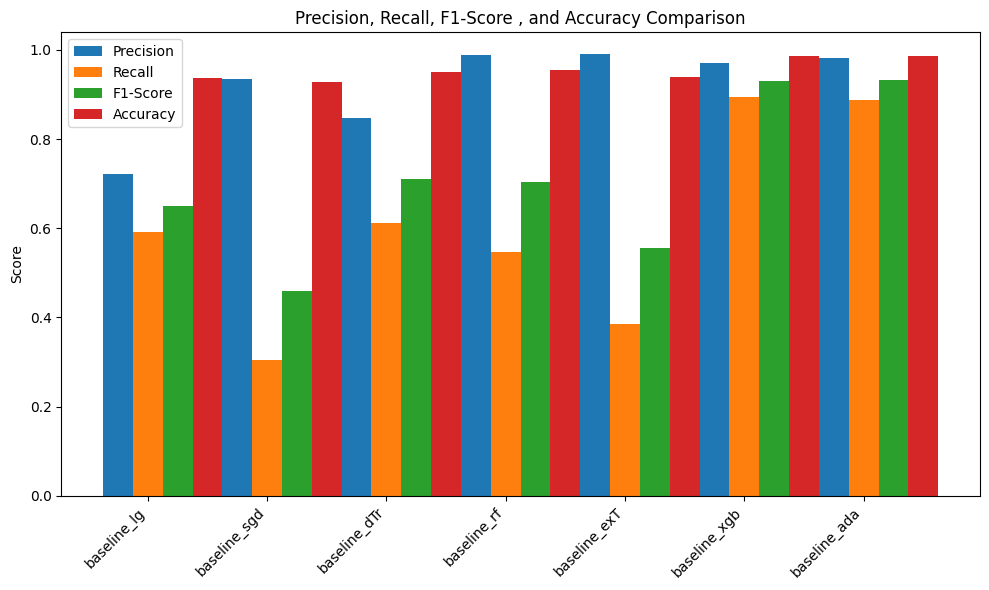

In [63]:
plot_metrics_comparison(baseline_summary)

The precision-recall curves provide a fascinating view of model performance on the EMNIST dataset, with ensemble methods like **AdaBoost** and **XGBoost** leading the pack. However, their hyperparameters shed light on some potential reasons for their performance differences.

### 1. AdaBoost vs. XGBoost
- AdaBoost achieves the best precision across most recall levels, with a particularly steep advantage in the mid-recall range. This could be attributed to its **base model**, a decision tree with a `max_depth` of 12, which allows it to capture deeper patterns compared to XGBoost’s shallower trees (`max_depth=5`). Additionally, AdaBoost relies on fewer hyperparameters, which might allow it to focus on iteratively correcting errors rather than balancing complex configurations.
- **XGBoost**, on the other hand, uses more nuanced regularization (`reg_lambda=10`, `colsample_bytree=0.8`, `subsample=0.5`) and a relatively smaller tree depth. These settings likely help it generalize better and avoid overfitting but may also limit its ability to capture intricate patterns in EMNIST’s handwritten digits, particularly at high recall levels.
- While AdaBoost currently outperforms XGBoost, further hyperparameter tuning for XGBoost—such as increasing `max_depth` or fine-tuning `learning_rate`—could reveal whether this difference is fundamental or simply due to suboptimal settings.

### 2. Random Forest vs. Extreme Trees
- **Random Forest** holds its precision longer as recall increases compared to Extreme Trees. This is likely due to its **`min_samples_split=8` and `min_samples_leaf=6`**, which enforce stricter splits and make individual trees more robust. However, the fewer number of estimators (`n_estimators=50`) could limit its diversity in decision boundaries.
- **Extreme Trees** (using `n_estimators=100`) benefit from their greater number of trees and more aggressive splitting (`min_samples_split=2`, `min_samples_leaf=2`). This likely explains why they perform competitively in the earlier recall range but falter as recall increases, potentially due to overfitting fine-grained patterns.
- The comparison highlights how a carefully calibrated forest (Random Forest) can outperform a more aggressive ensemble (Extreme Trees). However, increasing Random Forest’s `n_estimators` or adjusting its split criteria might further enhance its performance.

### 3. Single Decision Tree vs. Random Forest
- The **Decision Tree** understandably struggles, with precision dropping rapidly beyond a recall of ~0.6. Its performance is constrained by the lack of diversity and ensembling. In contrast, **Random Forest** benefits significantly from combining multiple trees with random feature splits (`max_features='sqrt'`), which reduces overfitting and captures more robust decision boundaries. This stark contrast showcases how ensembling transforms weak learners into strong ones.

### 4. Linear Models (Logistic Regression and SGDClassifier)
- Linear models predict probabilities based on simple, global decision boundaries, making them fundamentally ill-suited for the multi-class EMNIST dataset with its complex digit patterns. The weaker precision across the recall range reflects their inability to capture non-linear relationships. This aligns with expectations, as the dataset demands models capable of capturing intricate details—something tree-based ensembles excel at.

### 5. The Path Forward
- While the current results favor AdaBoost and XGBoost, the next step is **grid search hyperparameter tuning** for all models. For instance:
  - XGBoost could benefit from tuning `max_depth` and `subsample` for better recall handling.
  - Random Forest might improve with more estimators or relaxed split criteria.
  - Extreme Trees may benefit from additional regularization or fewer estimators.
- These refinements will help clarify whether AdaBoost’s current dominance is due to superior inherent performance or favorable hyperparameter choices.


### 2.3.3. Analysis of Precision-Recall Curve

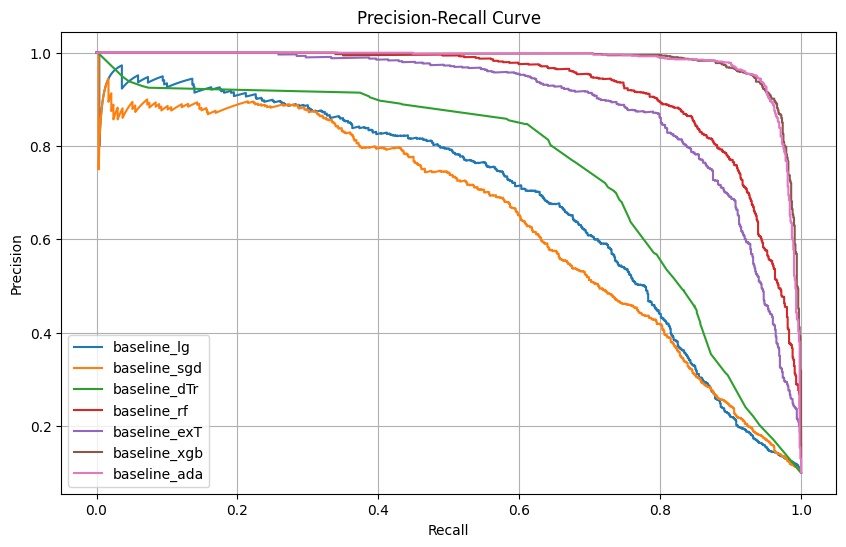

In [64]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr_curve(models, X_test, y_test):
    """
    plot a precision-recall curve for all models.

    args:
    - models (dict): Dictionary of trained models with their names as keys.
    - X_test (ndarray): Test features.
    - y_test (ndarray): Test labels.
    """
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        try:
            # Obtain probabilities or decision scores
            if hasattr(model, "predict_proba"):
                y_pred_prob = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_pred_prob = model.decision_function(X_test)
            else:
                print(f"Model {model_name} does not support `predict_proba` or `decision_function`. Skipping.")
                continue

            # Compute precision and recall
            precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
            plt.plot(recall, precision, label=model_name)
        except Exception as e:
            print(f"An error occurred while processing model {model_name}: {e}")
            continue

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

plot_pr_curve(models, validation_X_train, validation_y_8)

## 2.3.4. Precision-Recall vs. Threshold: An Analysis

The **Precision-Recall vs. Threshold** analysis helps visualize how a model's precision and recall trade off as the decision threshold changes. By examining these curves, we can understand how confidently a model makes predictions and identify threshold ranges that balance precision and recall effectively.  

### Observations:
1. **Threshold Behavior Across Models:**
   - Models like **Logistic Regression** and **SGDClassifier** display a smoother, monotonic transition between high precision and high recall across thresholds. This reflects their simplicity, as they compute probabilities based on global linear decision boundaries.
   - Ensemble models such as **AdaBoost**, **XGBoost**, and **Random Forest** exhibit more complex curves, with certain thresholds maintaining high precision and recall simultaneously. This demonstrates their ability to model non-linear relationships effectively.

2. **Sharp Precision Drop for Some Models:**
   - Precision for **Random Forest** and **Extreme Trees** starts high at low thresholds but drops sharply around threshold values near zero. This suggests that these models assign confident probabilities to their predictions for most samples but struggle when thresholds are increased to include harder cases.

3. **AdaBoost’s Consistency:**
   - **AdaBoost** maintains a high balance between precision and recall over a broader threshold range compared to other models. This likely stems from its use of a deep base decision tree (`max_depth=12`), which allows it to better differentiate between classes even as the threshold varies.

4. **Decision Tree Limitations:**
   - The single **Decision Tree** model shows a rapid drop in precision and recall at higher thresholds. This aligns with expectations, as it lacks the ensemble strength of Random Forest or AdaBoost to handle uncertainty in complex cases.

5. **Impact of Regularization:**
   - For **XGBoost**, the regularization parameters (`reg_lambda=10`, `subsample=0.5`) appear to smooth the precision-recall trade-off but limit peak precision at certain thresholds. This suggests that the model sacrifices some sharpness in confidence for better generalization.

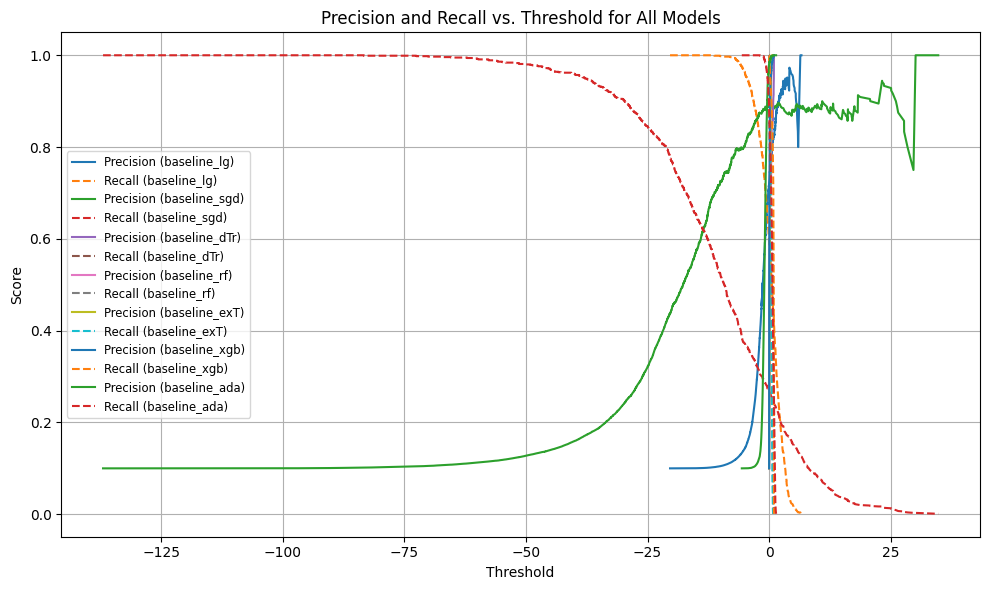

In [65]:
def plot_precision_recall_vs_threshold(models, X_test, y_test):
    """
    plot Precision and Recall vs. decision threshold for all models on a single plot.
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, model in models.items():
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        elif hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            raise ValueError(f"Model {model_name} does not support decision_function or predict_proba.")
        
        # Calculate precision, recall, and thresholds
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
        
        # Plot precision and recall vs. thresholds
        plt.plot(thresholds, precisions[:-1], linestyle='-', label=f"Precision ({model_name})")
        plt.plot(thresholds, recalls[:-1], linestyle='--', label=f"Recall ({model_name})")
    
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Threshold for All Models")
    plt.legend(loc="best", fontsize='small')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_precision_recall_vs_threshold(models, validation_X_train, validation_y_8)

## 2.3.5. Understanding ROC Curve

The **Receiver Operating Characteristic (ROC)** curves provide a comprehensive view of how well each model distinguishes between the classes in the EMNIST dataset. Below are key observations:

### Observations:

1. **Area Under the Curve (AUC) as a Metric of Discrimination:**
   - The **AUC values** for most models are remarkably high, with **Random Forest**, **XGBoost**, and **AdaBoost** achieving a perfect score of 1.00. This indicates excellent class separation capabilities.
   - Linear models like **Logistic Regression (AUC = 0.91)** and **SGDClassifier (AUC = 0.92)** also perform respectably but fall short of ensemble models, reflecting their limitations in capturing the non-linear relationships in handwritten digits.

2. **Ensemble Models Dominate:**
   - Ensemble methods (Random Forest, XGBoost, and AdaBoost) consistently maintain high True Positive Rates (TPR) across low False Positive Rates (FPR), as evidenced by their steep curves close to the top-left corner.
   - **AdaBoost's Strength**: Given its base decision tree with `max_depth=12`, AdaBoost’s superior performance likely stems from its ability to adaptively correct errors while maintaining robust decision boundaries.

3. **Extreme Trees vs. Random Forest:**
   - **Extreme Trees** (AUC = 0.99) slightly trail behind Random Forest (AUC = 1.00), likely due to their more aggressive splitting strategy (`min_samples_split=2`, `min_samples_leaf=2`). While this enables Extreme Trees to model fine-grained patterns, it may also introduce slight overfitting, reducing generalization.

4. **Decision Tree Limitations:**
   - The single **Decision Tree** model, despite achieving a high AUC of 0.92, demonstrates a less steep curve compared to ensembles. This highlights its inability to generalize as effectively as models that combine multiple trees.

5. **Random Guess Baseline:**
   - The diagonal dashed line (AUC = 0.5) represents random guessing, emphasizing that all models perform significantly better than chance.

In [66]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models, X_test, y_test):
    """
    plot an ROC curve for all models.
    
    args:
    - models (dict): Dictionary of models with their names.
    - X_test (ndarray): Test features.
    - y_test (ndarray): Test labels.
    """
    plt.figure(figsize=(10, 6))
    for model_name, model in models.items():
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

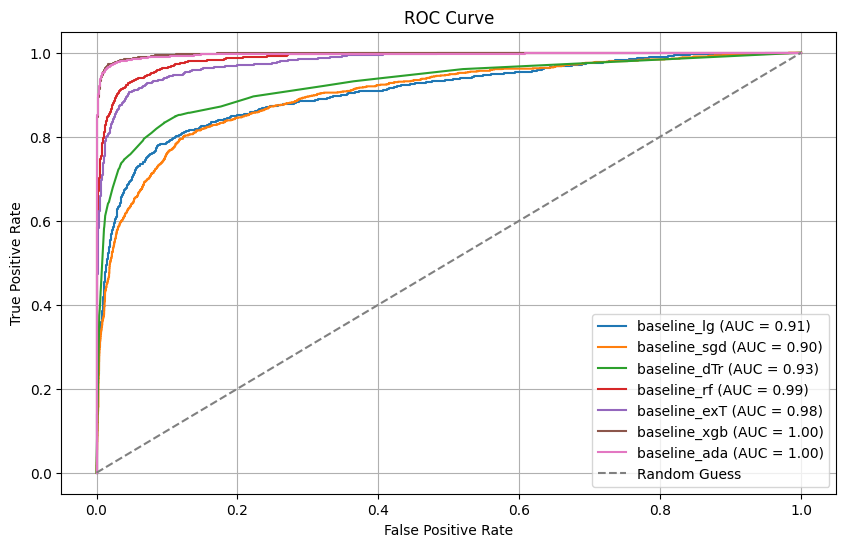

In [67]:
plot_roc_curve(models, validation_X_train, validation_y_8)

## 2.3.6. F1 Score vs. Threshold Analysis

The **F1 Score vs. Threshold** chart provides insights into the trade-offs between precision and recall for each model, with an emphasis on the decision threshold that maximizes the F1 score.

### Observations:

1. **Optimal Thresholds for Each Model:**
   - Most models reach their **maximum F1 scores** at thresholds close to 0. This aligns with the dataset's balanced nature, where thresholds near 0 are typically optimal for evenly distributed classes.
   - **AdaBoost** and **XGBoost** stand out, maintaining near-optimal F1 scores across a wide range of thresholds, reflecting their robustness and confidence in predictions.

2. **Model Comparisons at Max F1:**
   - The **ensemble models** (AdaBoost, XGBoost, and Random Forest) achieve consistently higher maximum F1 scores compared to linear models like Logistic Regression and SGDClassifier.
   - **AdaBoost** exhibits a particularly sharp rise and fall in F1 scores around its optimal threshold, highlighting its focus on confident, high-quality predictions.

3. **Linear Model Behavior:**
   - **Logistic Regression** and **SGDClassifier** show smoother and flatter F1 curves, suggesting they are less sensitive to threshold variations but also less capable of achieving high F1 scores due to their limited modeling capacity for non-linear relationships.

4. **Decision Tree vs. Random Forest:**
   - The single **Decision Tree** reaches a lower maximum F1 score compared to **Random Forest**, emphasizing the value of ensembling multiple weak learners to achieve stronger overall performance.
   - **Random Forest's** flatter peak indicates greater stability in predictions, likely due to its aggregation of multiple trees.

5. **Extreme Trees Trade-off:**
   - **Extreme Trees** exhibit a slightly lower peak compared to Random Forest, likely due to their aggressive splitting criteria, which may prioritize recall at the expense of precision.

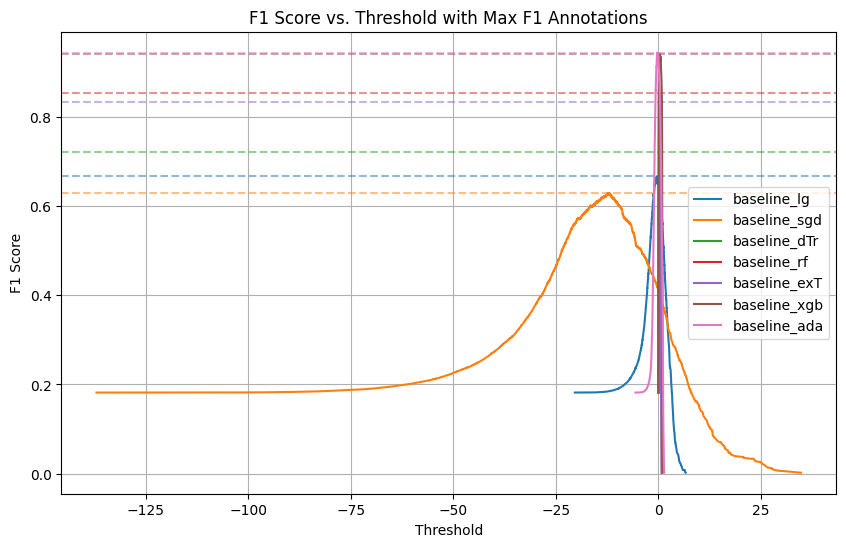

In [68]:
def plot_f1_vs_threshold_with_max(models, X_test, y_test):
    
    """
    plot F1 score vs. decision threshold for all models on a single plot,
    and annotate the max F1 score for each model with dotted lines.
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, model in models.items():
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        elif hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            raise ValueError(f"Model {model_name} does not support decision_function or predict_proba.")
        
        # Calculate precision, recall, and thresholds
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
        
        # Plot F1 score vs. thresholds
        plt.plot(thresholds, f1_scores[:-1], label=model_name)
        
        # Find max F1 score and its corresponding threshold
        max_idx = f1_scores.argmax()
        max_f1 = f1_scores[max_idx]
        best_threshold = thresholds[max_idx]
        
        # Add dotted lines for max F1 score
        #plt.axvline(x=best_threshold, color=plt.gca().lines[-1].get_color(), linestyle='--', alpha=0.5)
        plt.axhline(y=max_f1, color=plt.gca().lines[-1].get_color(), linestyle='--', alpha=0.5)

    
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs. Threshold with Max F1 Annotations")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_f1_vs_threshold_with_max(models, validation_X_train, validation_y_8)

## 2.4. Reliability Analysis of Baseline Models: Brier Scores

The Brier score measures the accuracy of probabilistic predictions. Unlike traditional classification metrics, which evaluate discrete decisions, the Brier score evaluates the entire probability distribution output by a model. It captures both the **calibration** (how well probabilities reflect actual outcomes) and the **sharpness** (confidence of predictions). The Brier score reflects a trade-off between **calibration and sharpness**. Models with high confidence predictions can achieve low Brier scores if they are well-calibrated. However, overconfident but incorrect predictions will dramatically increase the Brier score, signaling a calibration issue.
   
> $\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)^2$, where
> - $p$ is the predicted probability for the positive class for instance $i$,  
> - $y_i$ is the actual binary outcome for instance $i$ (0 or 1), and
> - $N$ is the total number of instances.  

#### Key Characteristics
1. **Range**: The Brier score ranges from 0 to 1. A score of 0 indicates perfect probabilistic predictions (e.g., $p_i = 1$ when $y_i = 1$, and $p_i = 0$ when $y_i = 0$). Higher values indicate poorer predictions.

2. **Penalization**: Predictions that are confident but incorrect (e.g., $p_i = 1$ when $y_i = 0$ are penalized more heavily than those closer to the neutral prediction $p_i = 0.5$).  

### Interpretation of Brier Score Values

A **low Brier score** (closer to 0) indicates well-calibrated predictions that are both sharp and accurate. In this case, the probabilities reflect the true likelihood of outcomes. For example, if a model predicts $p_i = 0.8$, the actual positive class frequency closely matches 80%. On the other hand, a **high Brier score** (closer to 1) suggests poorly calibrated predictions or overconfidence in incorrect predictions. For example, if a model consistently predicts $p_i = 1$ but the true outcomes deviate significantly, the score will be penalized heavily. This is a sign of either overfitting or a poor representation of the underlying data distribution.

In comparison to **random guessing**, a classifier that outputs a constant probability equal to the proportion of positive labels $p = \text{mean}(y)$ serves as a baseline. Any model achieving a Brier score better than this baseline has improved over random guessing.


### Analysis of the Barier Scores

The Brier scores above demonstrate that all classifiers outperform random guessing, which corresponds to a baseline Brier score of 0.09 (given the equal 10% representation of each digit in the test set). Notably, tree-based models such as AdaBoost (0.005), Random Forest (0.013), and Extreme Trees (0.025) significantly outperform linear models like Logistic Regression (0.051). This indicates that not only do the tree models excel in precision and recall, but they also show superior confidence in their probability assignments. This result highlights the robustness of tree-based classifiers in both predictive performance and reliability of their probabilistic outputs for this balanced multi-class classification task.

Calibrating baseline_sgd (SGDClassifier)...


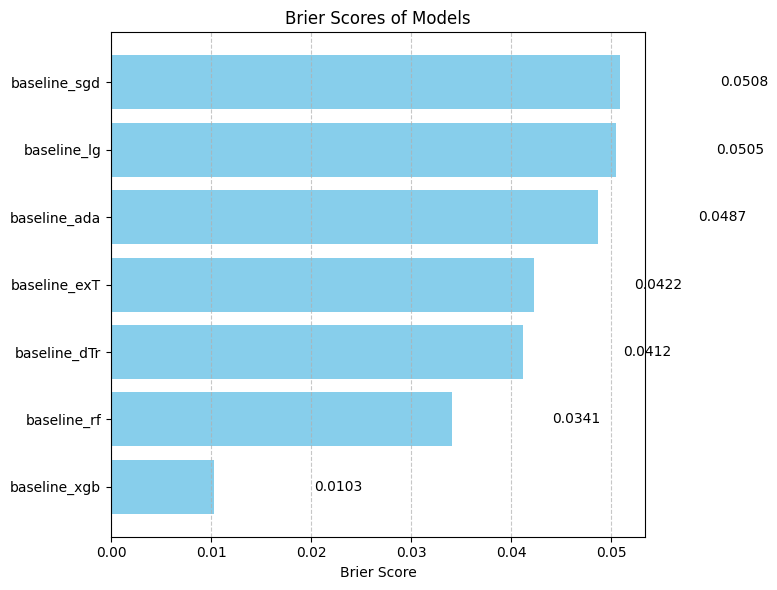

In [69]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

def calculate_brier_scores_with_calibration(models, X_test, y_test):
    """
    calculate Brier scores for models, calibrating those that lack `predict_proba` (e.g., `SGDClassifier`).

    args:
    - models (dict): Dictionary of models with their names as keys.
    - X_test (ndarray): Test feature data.
    - y_test (ndarray): True labels for the test data.

    returns:
    - brier_scores (dict): Dictionary of model names and their Brier scores.
    """
    brier_scores = {}

    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif isinstance(model, SGDClassifier):
            print(f"Calibrating {model_name} (SGDClassifier)...")
            calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
            calibrated_model.fit(X_test, y_test)
            y_prob = calibrated_model.predict_proba(X_test)[:, 1]
        else:
            print(f"Model {model_name} does not support `predict_proba`. Skipping.")
            continue

        brier_scores[model_name] = brier_score_loss(y_test, y_prob)

    return brier_scores

def plot_brier_scores(brier_scores):
    """
    plot Brier scores as a horizontal bar chart.

    args:
    - brier_scores (dict): Dictionary of model names and their Brier scores.
    """
    if not brier_scores:
        print("No models with `predict_proba` found. Cannot plot Brier scores.")
        return

    # sort scores for better visualization
    sorted_scores = dict(sorted(brier_scores.items(), key=lambda item: item[1]))

    plt.figure(figsize=(8, 6))
    plt.barh(list(sorted_scores.keys()), list(sorted_scores.values()), color="skyblue")
    plt.xlabel("Brier Score")
    plt.title("Brier Scores of Models")
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # annotate bars with score values
    for index, (model_name, score) in enumerate(sorted_scores.items()):
        plt.text(score + 0.01, index, f"{score:.4f}", va="center")

    plt.tight_layout()
    plt.show()


brier_scores = calculate_brier_scores_with_calibration(models, validation_X_train, validation_y_8)
plot_brier_scores(brier_scores)

# 2.5. Error Analysis

## 2.5.1. Confusion Matrix Analysis: One-vs-All

The confusion matrices provide a detailed breakdown of how well each model performs on the **validation set**, showing **true positives (TP)**, **true negatives (TN)**, **false positives (FP)**, and **false negatives (FN)**. Let’s take a closer look at what these numbers tell us about each model’s strengths and weaknesses for the EMNIST classification task.

### Analytical Observations

#### 1. AdaBoost and XGBoost: The Standout Performers
Notice how **AdaBoost** achieves the **lowest FP (17)** and FN (112) among all models. What does this mean? AdaBoost excels at correctly identifying both positive and negative cases, making it a balanced choice when both precision and recall are critical. Its use of a deep base decision tree (max_depth=12) likely helps it make well-informed splits, avoiding overgeneralization.

On the other hand, **XGBoost**, with slightly higher FP (27) and FN (106), still demonstrates strong generalization. Do you see the trade-off here? XGBoost might occasionally make more false positives than AdaBoost, but its robust regularization (`reg_lambda=10`, `subsample=0.5`) ensures consistent performance across datasets. If you’re working on a task where reducing false negatives is critical, both AdaBoost and XGBoost are excellent choices—but keep an eye on their slightly higher FP compared to Random Forest.

#### 2. Random Forest: A Precision-Oriented Model
Look at **Random Forest’s FP (7)**—the lowest among all models! This tells us Random Forest is highly precise, rarely misclassifying negatives as positives. But there’s a catch: its FN (453) is much higher than AdaBoost or XGBoost. What does this mean for you? If your application penalizes false positives more than false negatives (e.g., fraud detection), Random Forest might be the ideal choice. However, if missing true positives is costly, you may need to reconsider.

#### 3. Extreme Trees: Bias Toward Precision
Extreme Trees is an interesting case. With just **4 FP**, it is even more precise than Random Forest. But did you notice its FN (614)? That’s significantly higher. Extreme Trees sacrifices recall for precision, likely due to its aggressive splitting criteria (`min_samples_split=2`, `min_samples_leaf=2`). This makes it overly conservative resulting in missing a large portion of true positives. Think about this: Would you prioritize avoiding false positives so heavily that you risk overlooking critical true positives?

#### 4. Single Decision Tree: The Base Learner’s Limitation
With **110 FP** and **389 FN**, the single decision tree struggles noticeably compared to the ensembles. Why? Without the collaborative decision-making power of ensembles, it fails to balance precision and recall effectively. If you’ve ever wondered why ensemble methods are so popular, this is a great example—ensembles like Random Forest or AdaBoost can drastically improve both robustness and accuracy over a single decision tree.

#### 5. Linear Models: Struggling with Complexity
Now let’s consider the linear models: **Logistic Regression** (FP: 228, FN: 409) and **SGDClassifier** (FP: 34, FN: 732). Do these numbers surprise you? These models are inherently limited by their linear decision boundaries, which simply can’t capture the complex, non-linear relationships in EMNIST’s digit classification task. If your dataset is highly structured or linear, these models might perform acceptably. But for EMNIST, ensemble and tree-based models are clearly the better fit.

### Bringing It All Together
What does this mean for our model selection? If your goal is high recall (minimizing FN), you’d likely gravitate toward AdaBoost or XGBoost. If precision is your top priority (minimizing FP), Random Forest and Extreme Trees are strong contenders. And if your constraints include simplicity or interpretability, linear models might still have a role to play. What would you choose given these trade-offs? By keeping these insights in mind, we can tailor our models to the specific demands of the task at hand. Now, let us continue to evaluate these models and explore their deeper intricacies.

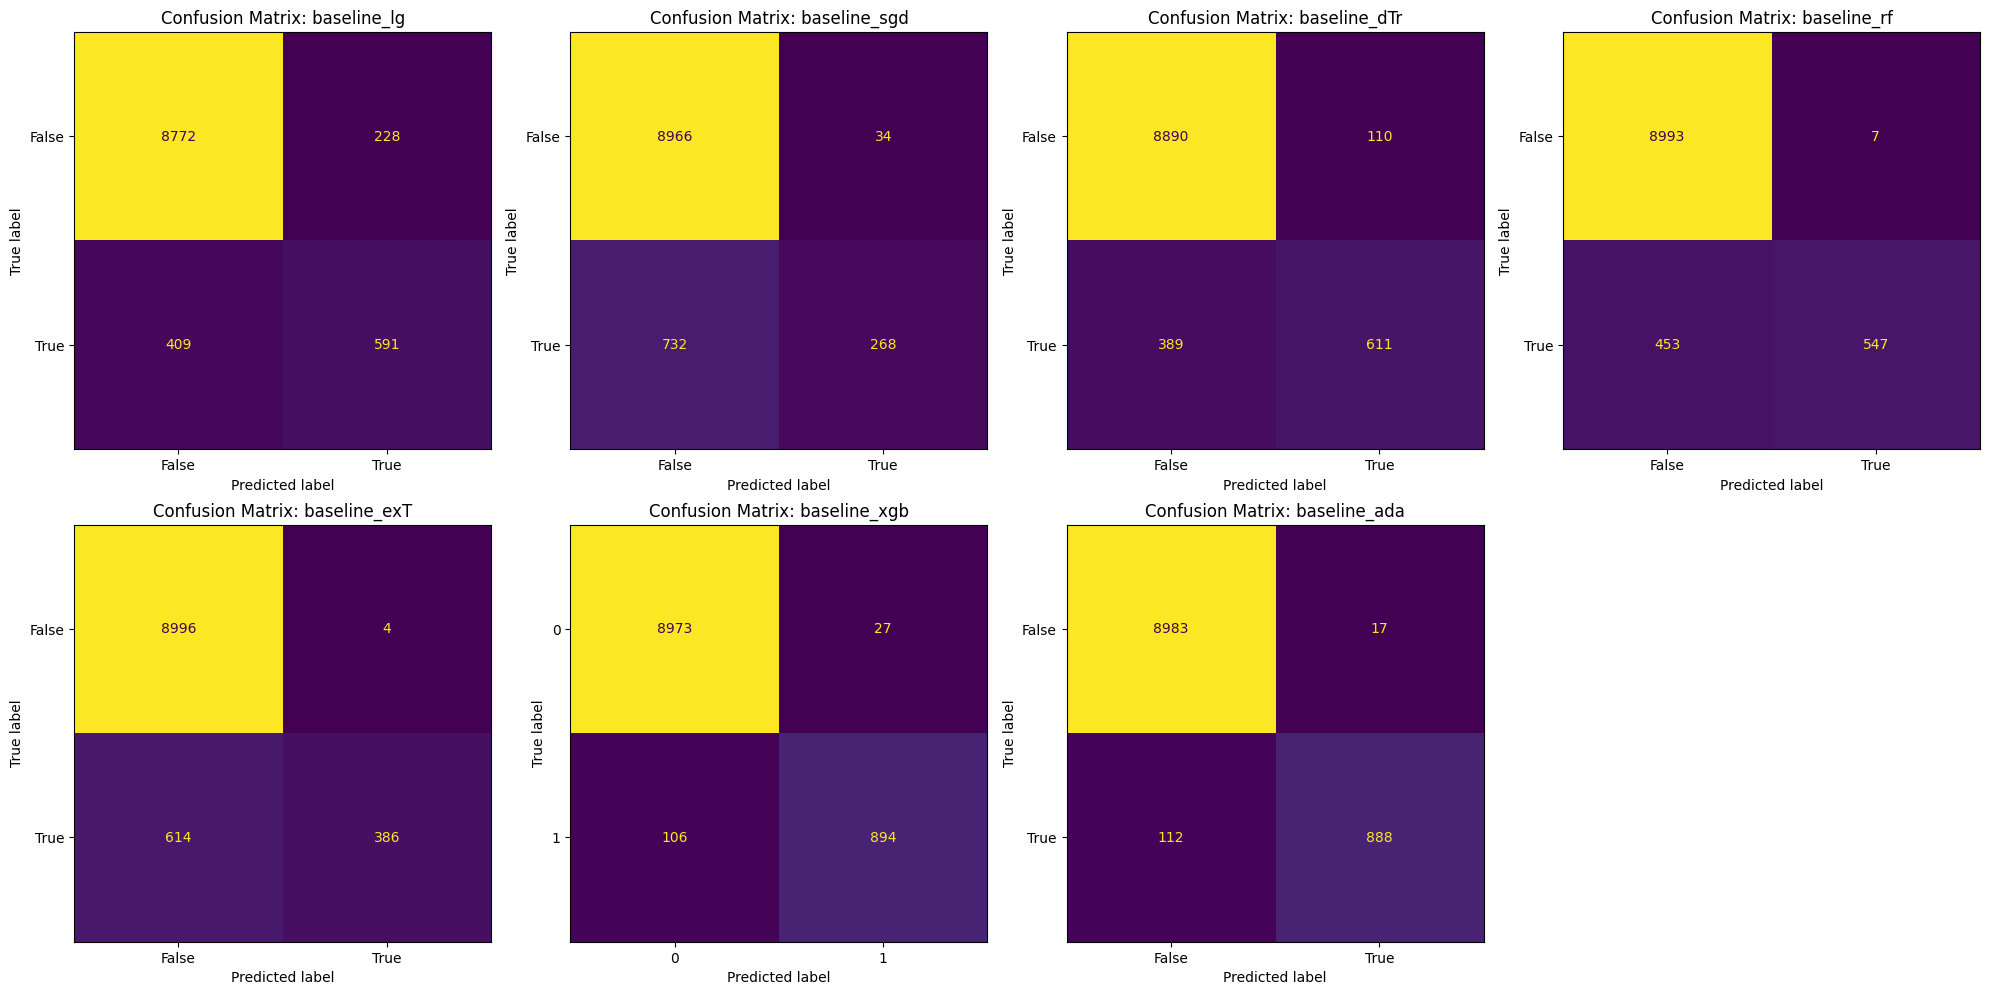

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

def plot_confusion_matrices(models, X_test, y_test):
    
    """
    plot confusion matrices for all models, with three matrices per row.

    args:
    - models (dict): Dictionary of models with their names.
    - X_test (ndarray): Test features.
    - y_test (ndarray): Test labels.
    """
    n_models = len(models)
    n_cols = 4  # Number of confusion matrices per row
    n_rows = math.ceil(n_models / n_cols)  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case there's only one row
    
    # clear any unused subplots
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    for ax, (model_name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(ax=ax, cmap="viridis", colorbar=False)
        ax.set_title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

# example Usage
plot_confusion_matrices(models, validation_X_train, validation_y_8)

### Overall Insights
**AdaBoost and XGBoost** overall are much better performers for balancing FP and FN. They are particularly suited for tasks where both precision and recall are critical. **Random Forest** can be ideal for precision-critical tasks, with minimal FP but at the expense of FN. **Extreme Trees** seems overly conservative by focusing heavily on minimizing FP but sacrificing recall significantly. **Linear Models** struggle with EMNIST’s complexity as expected and are not competitive against tree-based models.

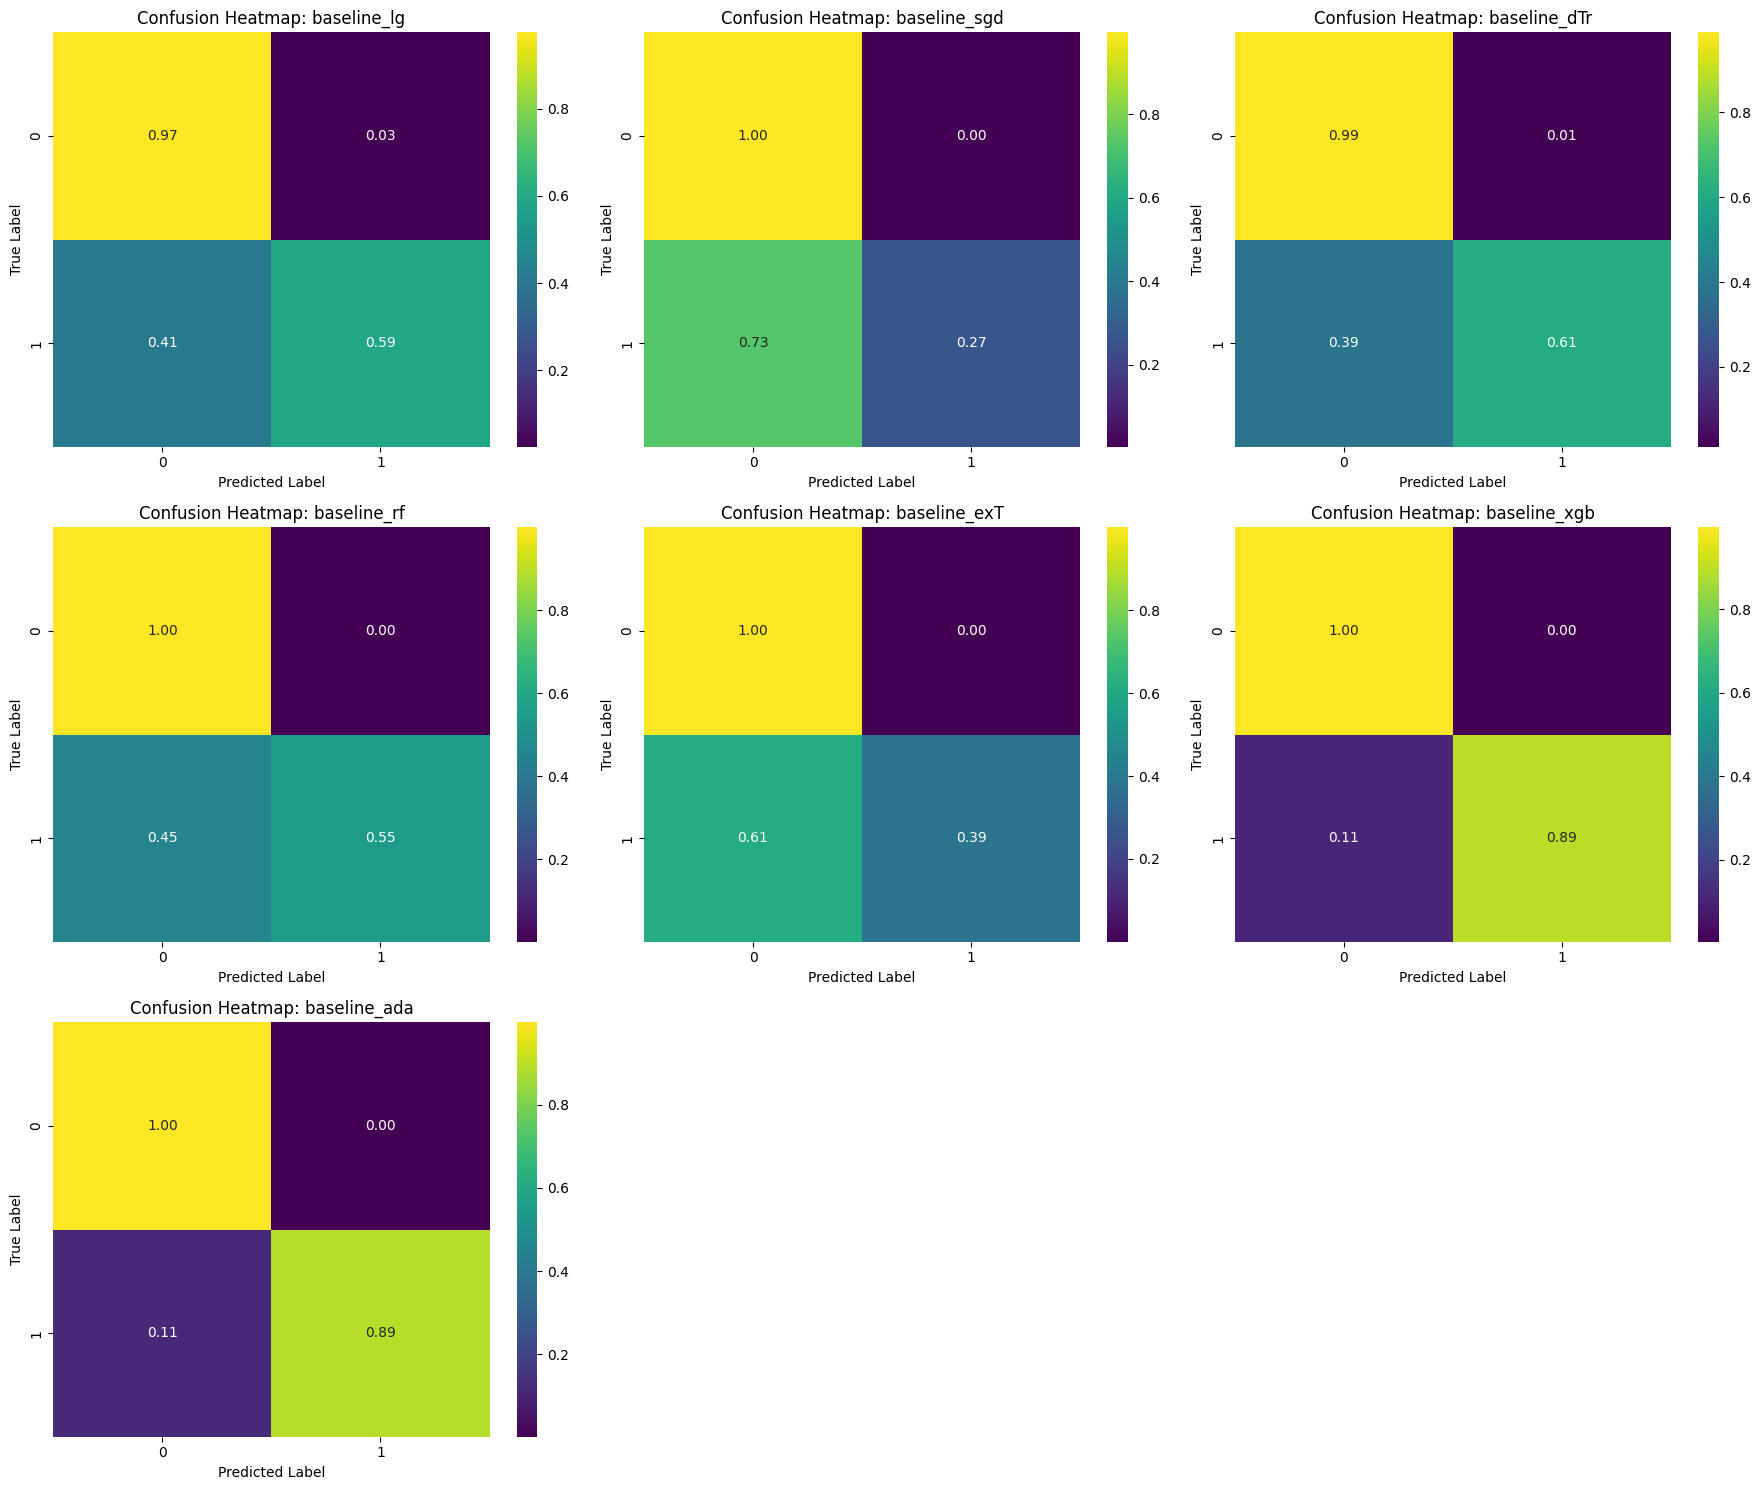

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_confusion_heatmaps(models, X_test, y_test):
    """
    plot confusion matrix heatmaps for all models, with three heatmaps per row.

    args:
    - models (dict): Dictionary of models with their names.
    - X_test (ndarray): Test features.
    - y_test (ndarray): Test labels.
    """
    n_models = len(models)
    n_cols = 3  # Number of heatmaps per row
    n_rows = math.ceil(n_models / n_cols)  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case there's only one row

    # clear any unused subplots
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    for ax, (model_name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize="true")  # Normalize for better visualization
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="viridis", ax=ax, cbar=True)
        ax.set_title(f"Confusion Heatmap: {model_name}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

plot_confusion_heatmaps(models, validation_X_train, validation_y_8)

### 2.5.2. A More Granular Analysis: One-vs-One Confusion Heatmaps

The following heatmaps present a granular breakdown of model performance by analyzing confusion matrix components—**True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**—for digit `8` compared to every other digit in the validation set. This detailed view provides insights into specific challenges faced by each model when distinguishing `8` from other digits. While this binary analysis doesn't identify which incorrect digit `8` was mistaken for, it sheds light on the structural patterns driving misclassification, paving the way for improvements in data representation and model design.

### 2.5.2.1. True Negatives (TN): The Models' Strengths

True Negatives represent instances correctly classified as "not 8." The heatmaps highlight models like **XGBoost** and **AdaBoost**, which consistently achieve near-perfect TN values across all compared digits. For instance, both models achieve TN values exceeding **995** for digits like `4`, `5`, and `6`, demonstrating their exceptional ability to avoid false alarms. In contrast, **Logistic Regression** and **SGDClassifier** show slightly lower TN values for digits such as `2` and `9`, suggesting these models struggle to establish clear boundaries between `8` and certain rounded or complex digits.

This high TN performance in ensemble models reflects their ability to robustly generalize patterns that separate `8` from dissimilar digits. These observations highlight ensemble methods as reliable choices when avoiding false positives is critical.

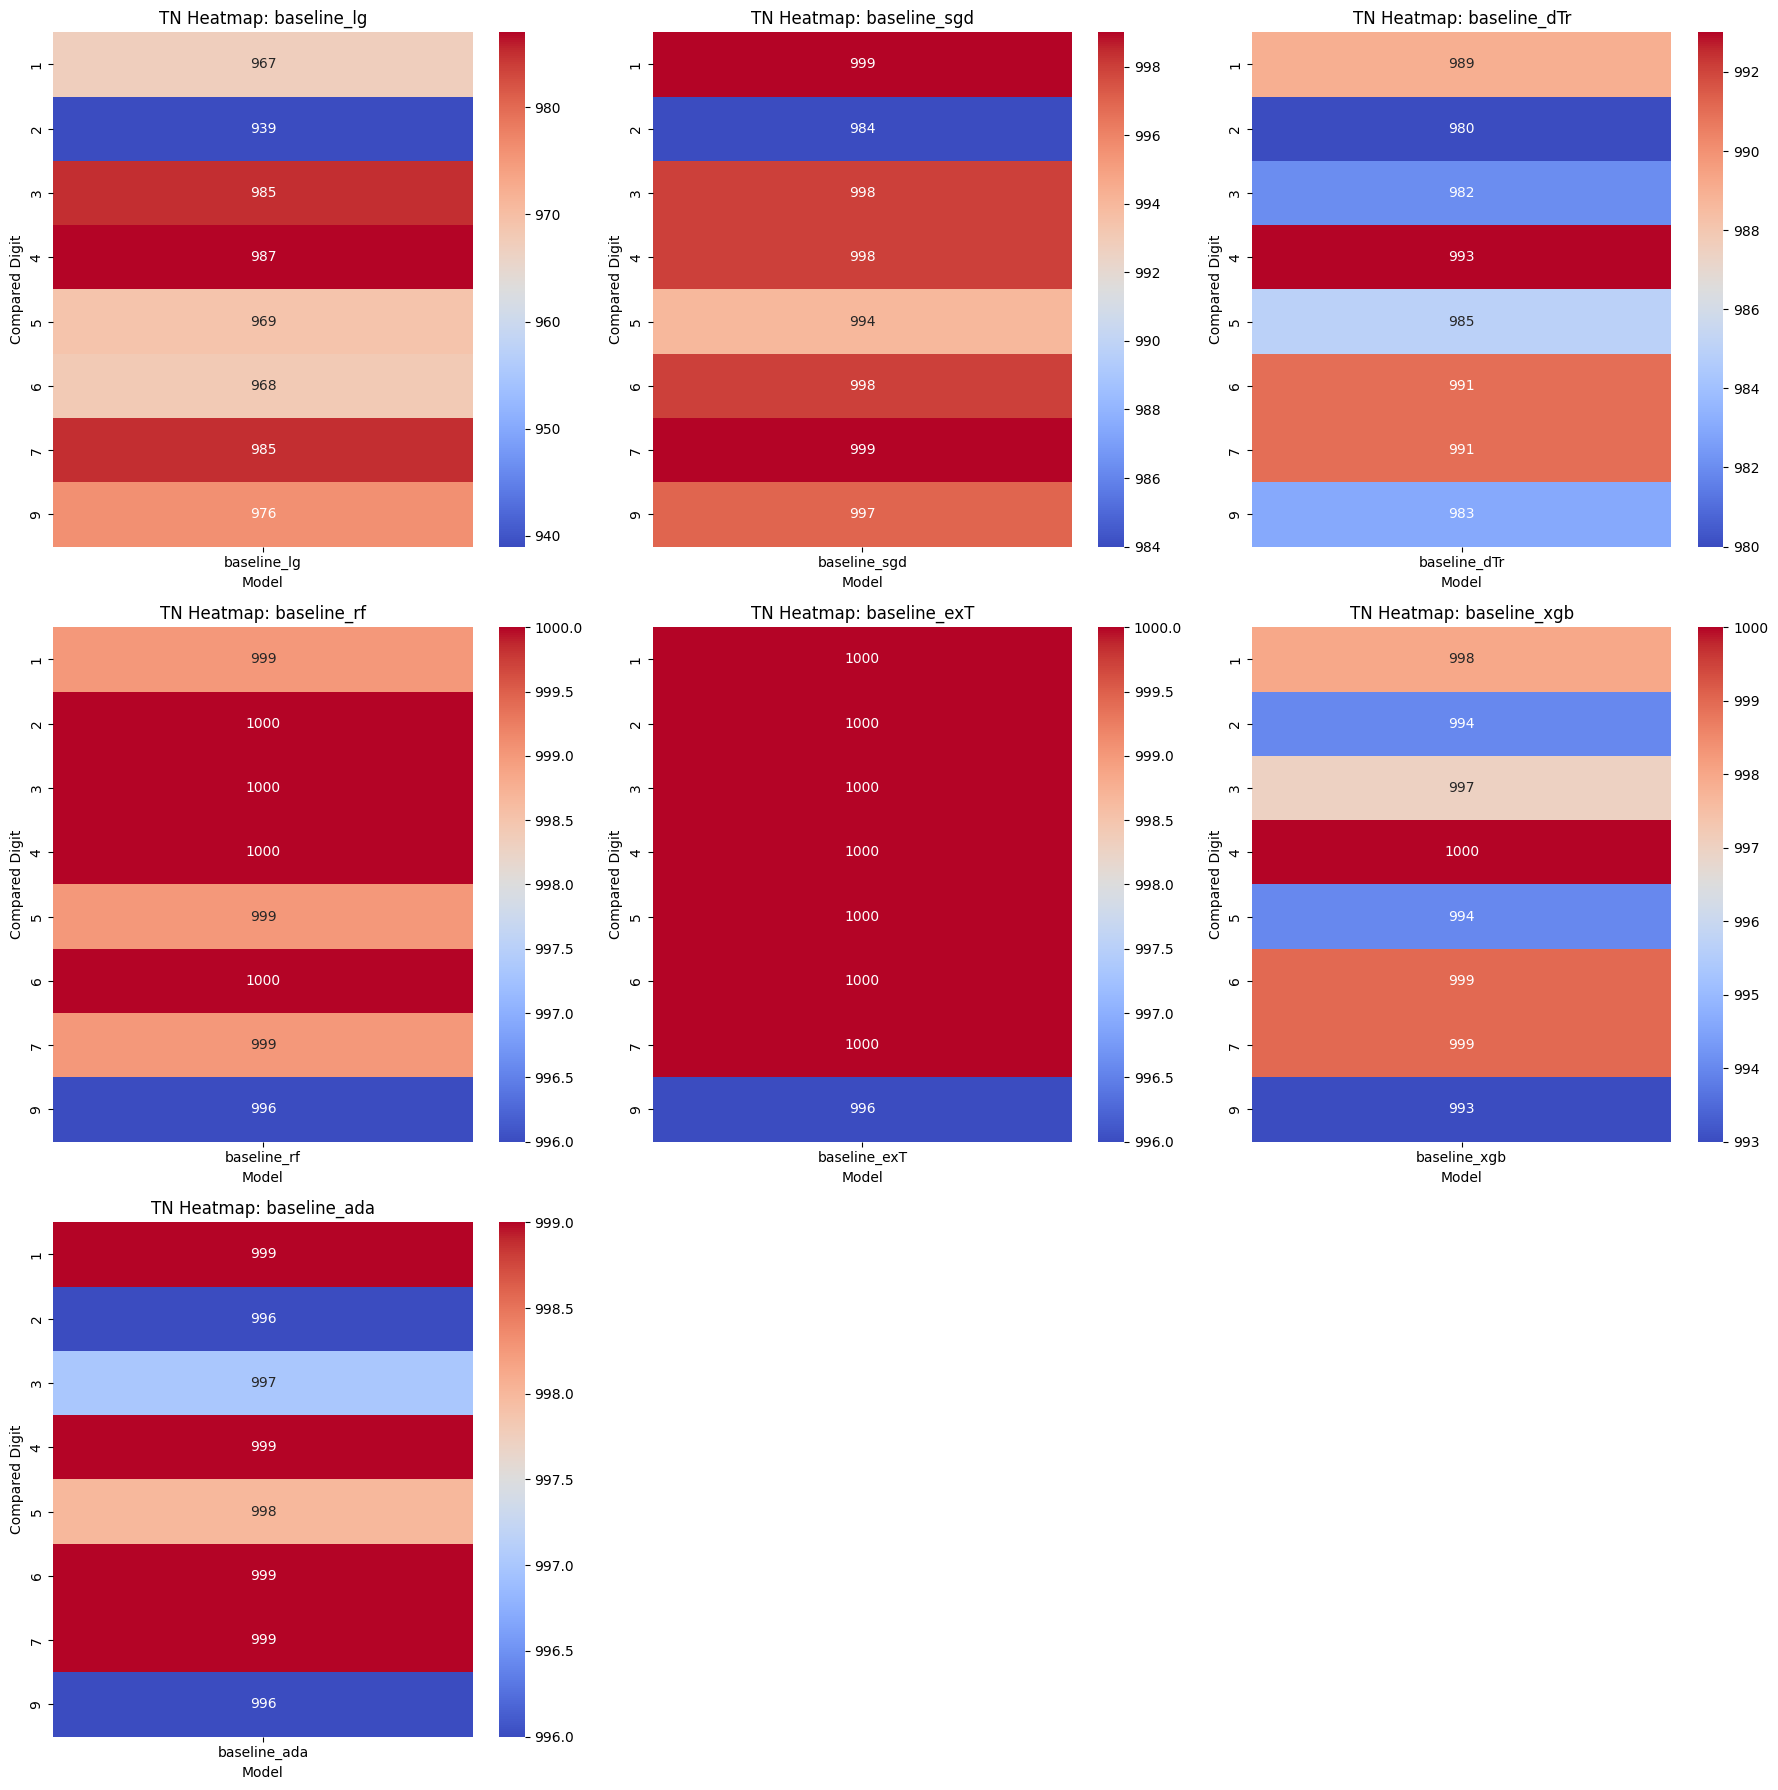

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confusion_heatmap_8_vs_all(models, X, y, class_names, metrics=None):
    """
    visualize confusion heatmap illustrating how each model is performing for digit 8 vs each digit.

    args:
    - models (dict): Dictionary of models with their names.
    - X (ndarray): Flattened feature data (e.g., test_digits_flattened).
    - y (ndarray): Labels corresponding to the feature data (e.g., test_digits_labels).
    - class_names (list): List of class names (digits 0-9).

    returns:
    - df_results (DataFrame): DataFrame containing TP, FP, TN, FN for each model and digit.
    """
    results = []

    for digit in class_names:
        # indices for digit 8 and the current digit
        idx_8 = np.where(y == 8)[0]
        idx_digit = np.where(y == digit)[0]
        
        # combine indices for binary classification
        binary_idx = np.concatenate([idx_8, idx_digit])
        X_binary, y_binary = X[binary_idx], y[binary_idx]
        
        # binary labels: 1 for digit 8, 0 for the current digit
        y_binary_labels = np.where(y_binary == 8, 1, 0)
        
        for model_name, model in models.items():
            # predictions for binary classification
            y_pred = model.predict(X_binary)
            # calculate confusion matrix
            cm = confusion_matrix(y_binary_labels, y_pred, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()
            
            # store results
            results.append({
                "Model": model_name,
                "Compared Digit": digit,
                "TP": tp,
                "FP": fp,
                "TN": tn,
                "FN": fn
            })

    # convert results to DataFrame
    df_results = pd.DataFrame(results)

    # visualize confusion metrics as heatmaps
    #metrics = ["FP", "TN"]
    for metric in metrics:
        n_models = len(models)
        n_cols = 3  # number of heatmaps per row
        n_rows = -(-n_models // n_cols)  # ceiling division for rows

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
        axes = axes.flatten()

        for i, model_name in enumerate(df_results["Model"].unique()):
            ax = axes[i]
            model_data = df_results[df_results["Model"] == model_name]
            heatmap_data = model_data.pivot(index="Compared Digit", columns="Model", values=metric)

            sns.heatmap(
                heatmap_data,
                annot=True,
                fmt=".0f",
                cmap="coolwarm",
                cbar=True,
                ax=ax
            )
            ax.set_title(f"{metric} Heatmap: {model_name}")
            ax.set_xlabel("Model")
            ax.set_ylabel("Compared Digit")

        # remove unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    return df_results

class_names = [1, 2, 3, 4, 5, 6, 7, 9]
df_results = confusion_heatmap_8_vs_all(models, validation_X_train, validation_y, class_names, metrics=["TN"])

### 2.5.2.2. False Negatives (FN): The Toughest Challenges

False Negatives, where the digit `8` is incorrectly classified as another digit, pose unique challenges. Digits like `3` and `7` frequently show high FN rates, especially in simpler models like **Logistic Regression** and **SGDClassifier**. For instance, the FN rate for digit `7` is **43.1%** in Logistic Regression, a stark contrast to the **7.6%** achieved by **XGBoost**. Similarly, for digit `3`, FN percentages drop from **41.9%** in Logistic Regression to just **7.2%** in **AdaBoost**.

The high FN rates for these digits often stem from shared visual features—`7` may resemble `1` or `9`, while `3` might overlap with `5` or `8`. Ensemble methods excel in minimizing these errors by leveraging diverse decision boundaries. However, addressing FN requires targeted strategies like data augmentation for challenging digits or adjusting loss functions to penalize FN cases more heavily.

### 2.5.2.3. False Positives (FP): The Confusing Lookalikes

False Positives occur when digits other than `8` are mistakenly classified as `8`. The heatmaps reveal that digits like `5`, `6`, and `9` are frequent culprits across all models, likely due to their shared loops or rounded shapes. For example, **Logistic Regression** exhibits an FP rate of **3.2%** for digit `5`, significantly higher than the **0%** achieved by ensemble models like **Random Forest** and **XGBoost**.

Interestingly, boosting models such as **AdaBoost** and **XGBoost** consistently achieve **0% FP** for digits like `4` and `7`, underscoring their strength in minimizing these errors. These results suggest that refined feature extraction—capturing subtle differences like stroke curvature or symmetry—could further reduce FP for challenging digits. For practical deployments, minimizing FP for visually similar digits like `5` and `6` could significantly enhance user trust in the model.

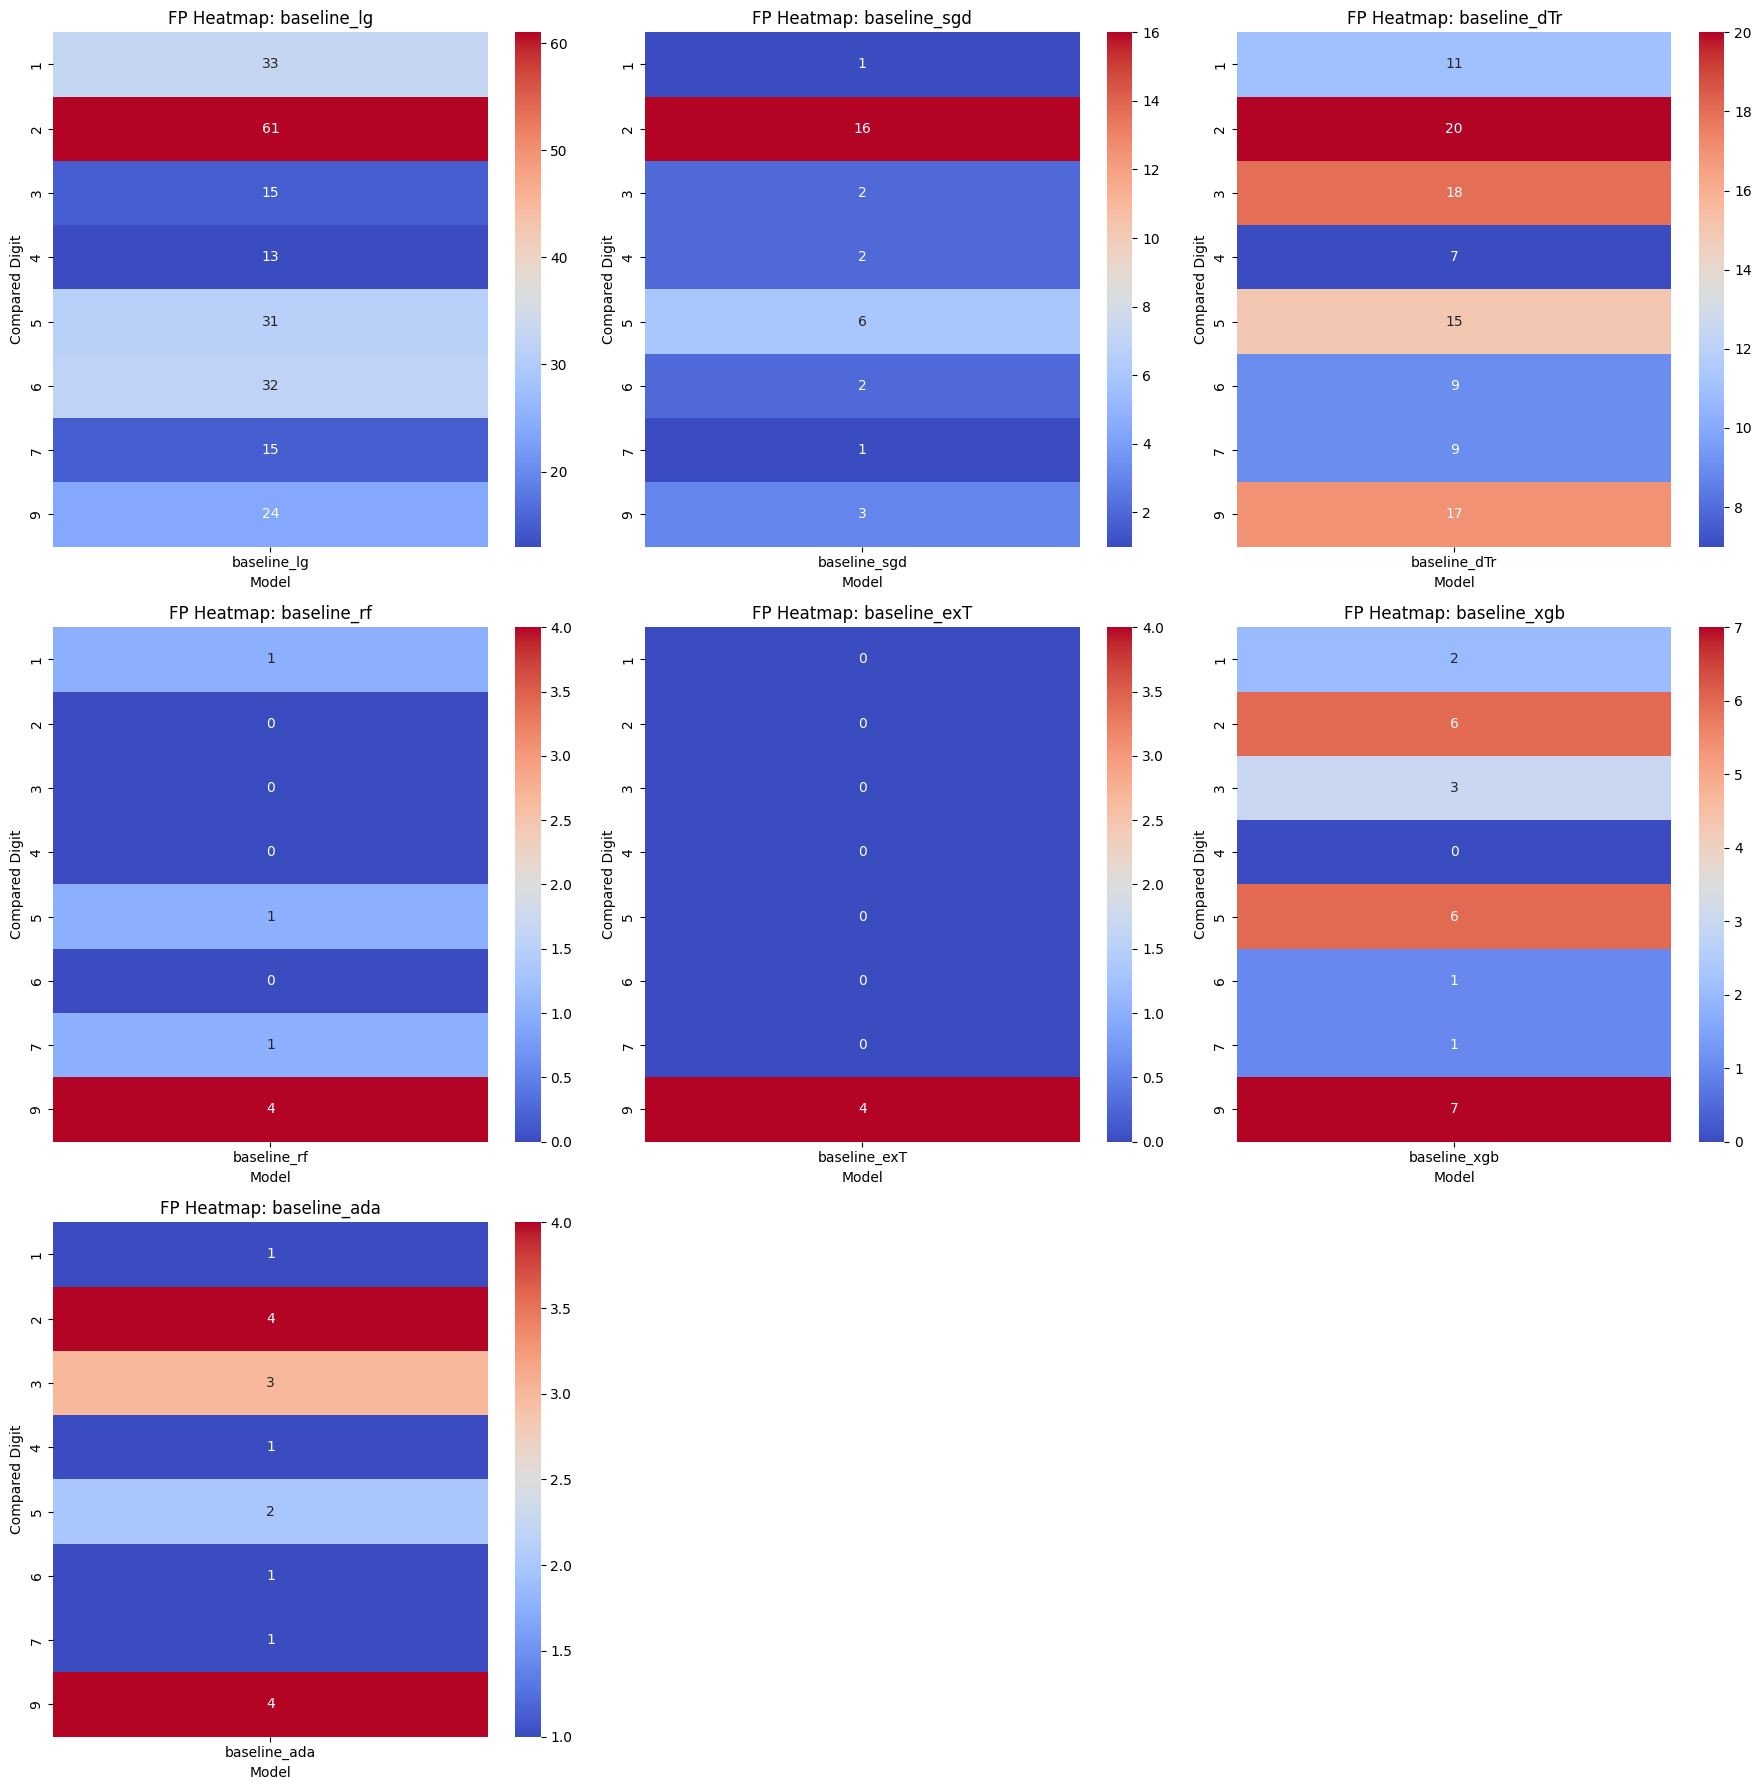

In [73]:
df_results = confusion_heatmap_8_vs_all(models, validation_X_train, validation_y, class_names, metrics=["FP"])

## 2.6. Visualization of Missclassified Digits

We now have statistics of the missclassified images, both those which are mistakenly taken to be 8, and those images of the digit 8 which are incorrectly classified otherwise. But how do these images look like? 

In this section, we find all the these images, and visualize some of them so that (a) we have a tangible observation of their charachteristics, and (b) use this understanding to devise techniques and ways for tackling the challenges of getting them right in a manner that improves the precision and recall to an acceptable level.  

In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def compute_misclassified(models, X, y, class_names):
    """
    visualize confusion heatmap illustrating how each model is performing for digit 8 vs each digit,
    and record where each model misclassifies.

    args:
    - models (dict): Dictionary of trained models with their names as keys.
    - X (ndarray): Flattened feature data (e.g., test_digits_flattened).
    - y (ndarray): Labels corresponding to the feature data (e.g., test_digits_labels).
    - class_names (list): List of class names (digits 0-9).

    returns:
    - df_results (DataFrame): DataFrame containing TP, FP, TN, FN for each model and digit.
    - misclassified_dict (dict): Nested dictionary showing misclassified indices for each digit and model.
    """
    results = []
    misclassified_dict = {digit: {model_name: [] for model_name in models.keys()} for digit in class_names}

    for digit in class_names:
        # Indices for digit 8 and the current digit
        idx_8 = np.where(y == 8)[0]
        idx_digit = np.where(y == digit)[0]
        
        # combine indices for binary classification
        binary_idx = np.concatenate([idx_8, idx_digit])
        X_binary, y_binary = X[binary_idx], y[binary_idx]
        
        # binary labels: 1 for digit 8, 0 for the current digit
        y_binary_labels = np.where(y_binary == 8, 1, 0)
        
        for model_name, model in models.items():
            try:
                # predictions for binary classification
                y_pred = model.predict(X_binary)
                
                # calculate confusion matrix
                cm = confusion_matrix(y_binary_labels, y_pred, labels=[0, 1])
                tn, fp, fn, tp = cm.ravel()
                
                # store misclassified indices (where predictions don't match true labels)
                misclassified_indices = binary_idx[y_pred != y_binary_labels]
                misclassified_dict[digit][model_name] = misclassified_indices
                
                # store results
                results.append({
                    "Model": model_name,
                    "Compared Digit": digit,
                    "TP": tp,
                    "FP": fp,
                    "TN": tn,
                    "FN": fn
                })
            except Exception as e:
                print(f"Error with model {model_name} for digit {digit}: {e}")

    # convert results to DataFrame
    df_results = pd.DataFrame(results)

    return df_results, misclassified_dict

class_names = [1, 2, 3, 4, 5, 6, 7, 9]  # Digits excluding 8

df_results, misclassified_dict = compute_misclassified(models, validation_X_train, validation_y, class_names)

It is useful to identify which images are more challenging for each group of models. Here, we focus on four categories: linear models, tree-based models, and the boosting models. Understanding how each group struggles provides valuable insights into their weaknesses and the potential reasons behind these struggles. This knowledge enables us to design tailored solutions for the group of models that aligns most closely with our objectives.

In [85]:
def analyze_misclassifications(misclassified_dict, linear_models, tree_models, boosting_models):
    """
    analyze misclassified indices based on model groups: linear models, tree models, boosting models, and all models.

    args:
    - misclassified_dict (dict): Dictionary containing misclassified indices for each digit and model.
    - linear_models (list): List of linear model names (e.g., ["baseline_lg", "baseline_sgd"]).
    - tree_models (list): List of tree-based model names (e.g., ["baseline_rf", "baseline_dTr", "baseline_exT"]).
    - boosting_models (list): List of boosting model names (e.g., ["baseline_xgb", "baseline_ada"]).

    returns:
    - misclassified_groups (dict): Dictionary with keys as groups and values as sets of misclassified indices.
    """
    all_digits = list(misclassified_dict.keys())
    all_models = list(misclassified_dict[all_digits[0]].keys())

    # initialize sets for misclassified indices for each group
    misclassified_groups = {
        "linear_models": set(),
        "tree_models": set(),
        "boosting_models": set(),
        "all_models": None,
    }

    # iterate through digits and collect misclassified indices
    for digit in all_digits:
        linear_indices = set()
        tree_indices = set()
        boosting_indices = set()
        all_indices = set()

        for model_name, indices in misclassified_dict[digit].items():
            indices_set = set(indices)
            all_indices.update(indices_set)

            if model_name in linear_models:
                linear_indices.update(indices_set)
            if model_name in tree_models:
                tree_indices.update(indices_set)
            if model_name in boosting_models:
                boosting_indices.update(indices_set)

        # update the misclassified groups
        misclassified_groups["linear_models"].update(linear_indices)
        misclassified_groups["tree_models"].update(tree_indices)
        misclassified_groups["boosting_models"].update(boosting_indices)

        # for "all_models", compute the intersection across all digits and models
        if misclassified_groups["all_models"] is None:
            misclassified_groups["all_models"] = all_indices
        else:
            misclassified_groups["all_models"] &= all_indices

    # ensure "all_models" is not None (e.g., no misclassifications at all)
    misclassified_groups["all_models"] = misclassified_groups["all_models"] or set()

    return misclassified_groups


# specify the model groups
linear_models = ["baseline_lg", "baseline_sgd"]
tree_models = ["baseline_rf", "baseline_dTr", "baseline_exT"]
boosting_models = ["baseline_xgb", "baseline_ada"]

# calc misclassifications
misclassified_groups = analyze_misclassifications(misclassified_dict, linear_models, tree_models, boosting_models)

print("Indices misclassified by linear models:", len(misclassified_groups["linear_models"]))
print("Indices misclassified by tree-based models:", len(misclassified_groups["tree_models"]))
print("Indices misclassified by boosting models:", len(misclassified_groups["boosting_models"]))
print("Indices misclassified by every model:", len(misclassified_groups["all_models"]))

Indices misclassified by linear models: 966
Indices misclassified by tree-based models: 765
Indices misclassified by boosting models: 160
Indices misclassified by every model: 856


In [86]:
import matplotlib.pyplot as plt

def visualize_misclassified_images(indices, X, y, group_name, n=10):
    """
    visualize misclassified images from a given group.

    args:
    - indices (set): Indices of misclassified images.
    - X (ndarray): Original image data (e.g., test_digits_images).
    - y (ndarray): True labels corresponding to the image data.
    - group_name (str): Name of the group (e.g., "linear_models", "tree_models").
    - n (int): Number of images to visualize.

    returns:
    - None
    """
    
    misclassified_indices = sorted(list(indices))
    
    # limit the number of images to display
    if n > len(misclassified_indices):
        n = len(misclassified_indices)
        print(f"Only {n} images available for group: {group_name}")

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices[:n]):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx], cmap="gray")
        #plt.title(f"True Label: {y[idx]}")
        plt.axis("off")
        
    plt.title(f"Misclassified Images By: {group_name}")
    plt.show()

### 2.6.1. Images Missclassified By The Linear Models

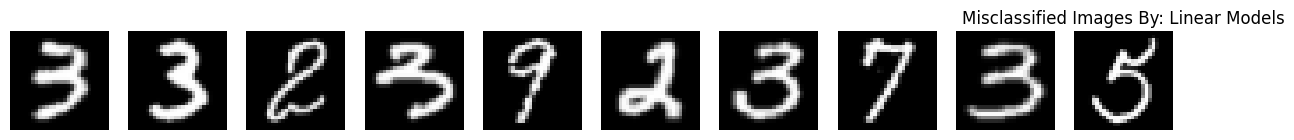

In [87]:
n_images_to_visualize = 10

# visualize misclassified images from each group
visualize_misclassified_images(
    indices=misclassified_groups["linear_models"], 
    X=test_digits_images, 
    y=test_digits_labels, 
    group_name="Linear Models", 
    n=n_images_to_visualize
)

### 2.6.2. Images Mistaken By Tree-based Models

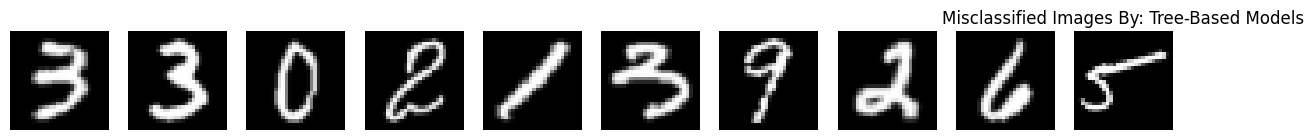

In [78]:
visualize_misclassified_images(
    indices=misclassified_groups["tree_models"], 
    X=test_digits_images, 
    y=test_digits_labels, 
    group_name="Tree-Based Models", 
    n=n_images_to_visualize
)

Let’s take a closer look at the misclassified images to see if we can spot any patterns. Do you notice any commonalities between the images in each group? Both the linear models and the tree-based ones (Random Forest and Extreme Trees) seem to have difficulties with noisy images—you know, those that are thicker than usual. This connects back to our introductory EDA, where we analyzed the variability of pixel density for each digit.

But differences in their misclassifications stand out too, don’t they? Look at the images that the tree models are getting wrong. Some of them are slightly rotated. And have you noticed how some of these digits, like 2 and 4, have loops where they normally shouldn’t? These observations highlight where the models struggle and give us ideas for how we might improve their performance.

### 2.6.3. Images Missclassified By The Boosting Models

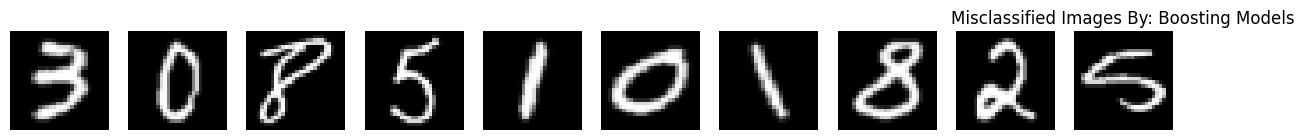

In [79]:
visualize_misclassified_images(
    indices=misclassified_groups["boosting_models"], 
    X=test_digits_images, 
    y=test_digits_labels, 
    group_name="Boosting Models", 
    n=n_images_to_visualize
)

Let us take a closer look at the digits incorrectly classified as 8 by the boosting models. Do you notice the patterns? Just like with the tree models, noisiness and tiltedness seem to be causing the trouble. But here’s something interesting—boosting models seem to handle digits without loops (like 2 and 4) much better than the tree models. Why is that? It is very likely because boosting mechanisms focus on the harder cases, helping these models push through those extra challenges and perform better where it really counts.

### 2.6.4. Missclassified By Every Model

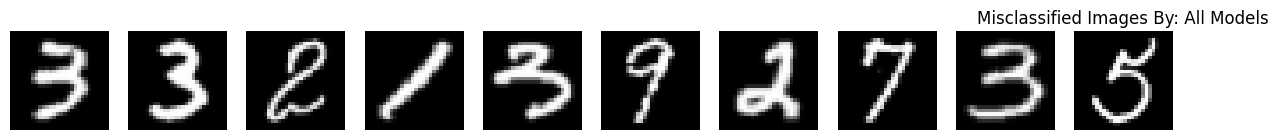

In [80]:
visualize_misclassified_images(
    indices=misclassified_groups["all_models"], 
    X=test_digits_images, 
    y=test_digits_labels, 
    group_name="All Models", 
    n=n_images_to_visualize
)

Last, we should a comparison of images which are missclassified between linear and tree-based methods (Random Forest, Extra trees, and the boosting ones).

Visualizing Tree Correct but Linear Wrong:


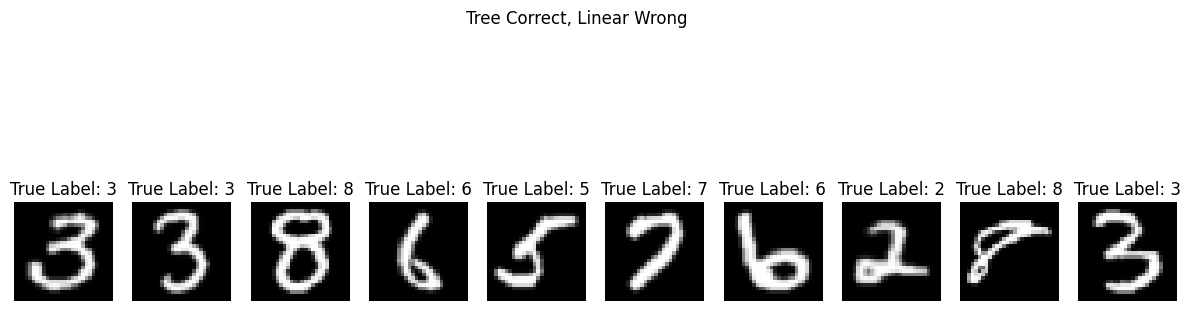

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def compare_misclassified_groups(misclassified_dict, X, y, tree_models, linear_models):
    """
    compare misclassified images between tree-based and linear models.

    args:
    - misclassified_dict (dict): Dictionary containing misclassified indices for each digit and model.
    - X (ndarray): Original image data (e.g., test_digits_images).
    - y (ndarray): True labels corresponding to the image data.
    - tree_models (list): List of tree-based model names.
    - linear_models (list): List of linear model names.

    returns:
    - comparison_results (dict): Contains images misclassified by one group but correct for another.
    """
    all_digits = list(misclassified_dict.keys())
    comparison_results = {
        "tree_correct_linear_wrong": set(),
        "linear_correct_tree_wrong": set()
    }

    for digit in all_digits:
        # union of misclassified indices for each group
        tree_misclassified = set()
        linear_misclassified = set()

        # collect misclassified indices for tree-based models
        for model in tree_models:
            if model in misclassified_dict[digit]:
                tree_misclassified.update(misclassified_dict[digit][model])

        # collect misclassified indices for linear models
        for model in linear_models:
            if model in misclassified_dict[digit]:
                linear_misclassified.update(misclassified_dict[digit][model])

        # identify differences between groups
        tree_correct_linear_wrong = linear_misclassified - tree_misclassified
        linear_correct_tree_wrong = tree_misclassified - linear_misclassified

        # update the comparison results
        comparison_results["tree_correct_linear_wrong"].update(tree_correct_linear_wrong)
        comparison_results["linear_correct_tree_wrong"].update(linear_correct_tree_wrong)

    return comparison_results

def visualize_comparison_images(indices, X, y, title, n=10):
    """
    visualize images from a comparison group.

    args:
    - indices (set): Indices of images for the group.
    - X (ndarray): Original image data (e.g., test_digits_images).
    - y (ndarray): True labels corresponding to the image data.
    - title (str): Title for the visualization.
    - n (int): Number of images to visualize.

    returns:
    - None
    """
    misclassified_indices = sorted(list(indices))
    if n > len(misclassified_indices):
        n = len(misclassified_indices)
        print(f"Only {n} images available for group: {title}")

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices[:n]):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx], cmap="gray")
        plt.title(f"True Label: {y[idx]}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()


tree_models = ["baseline_rf", "baseline_dTr", "baseline_exT"]
linear_models = ["baseline_lg", "baseline_sgd"]

comparison_results = compare_misclassified_groups(
    misclassified_dict=misclassified_dict,
    X=test_digits_images,
    y=test_digits_labels,
    tree_models=tree_models,
    linear_models=linear_models
)

n_images_to_visualize = 10

print("Visualizing Tree Correct but Linear Wrong:")
visualize_comparison_images(
    indices=comparison_results["tree_correct_linear_wrong"],
    X=test_digits_images,
    y=test_digits_labels,
    title="Tree Correct, Linear Wrong",
    n=n_images_to_visualize
)

Visualizing Linear Correct but Tree Wrong:


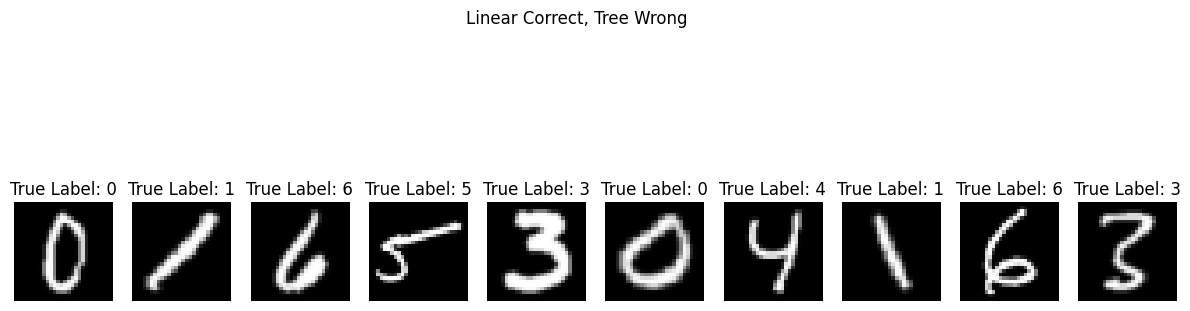

In [82]:
print("Visualizing Linear Correct but Tree Wrong:")
visualize_comparison_images(
    indices=comparison_results["linear_correct_tree_wrong"],
    X=test_digits_images,
    y=test_digits_labels,
    title="Linear Correct, Tree Wrong",
    n=n_images_to_visualize
)

### 2.7. Strategic Insights and Forward Planning

In the process of developing machine learning models, it is important to take a holistic perspective. Improvements in technical metrics such as precision and recall are valuable, but not at any cost. The acceptable thresholds for these metrics must be determined based on the requirements derived from the business objectives. Ideally, the decision-making process should involve a rational cost-benefit analysis that considers the project's specific requirements. This analysis should address questions like: what threshold of risk is acceptable, how much cost (in terms of time, computational resources, and person-hours) is reasonable, and what timeline should be allocated for deploying the model. For instance, if a project is time-sensitive, XGBoost may be prioritized due to its potential for excellent precision and recall, while also balancing computational efficiency. This decision-making framework will guide the engineering process, including the acceptable number of iterations for hyperparameter tuning, the trade-offs between metrics, and the optimal stopping point for model development.

Having established this context for interpreting the performance of baseline models and determining the path forward, our evaluation reveals that boosting models like XGBoost and AdaBoost are clear winners. These models consistently minimize false positives (FP) and false negatives (FN) while maintaining high true negative (TN) rates, demonstrating a robust balance between precision and recall. In contrast, linear models such as Logistic Regression and SGDClassifier struggle with capturing complex non-linear relationships, limiting their effectiveness.
  
To further enhance performance, especially for challenging digits, we have some options before us:

1. **Hyperparametr Tuning**: Baseline evaluations have provided valuable insights into potential improvements. For tree-based models, parameters like `max_depth` and `n_estimators` can be increased to enhance performance. Additionally, increasing `max_features` allows models to explore more features during splits, improving their ability to capture patterns in noisy or rotated images currently misclassified.

2. **Voting and Stacking Ensembles**: After a few iterations of hyperparameter tuning, we will conduct another round of error analysis to examine error distributions and variability. Our baseline analysis and visualizations already suggest that different models make distinct types of errors, providing an opportunity for ensemble methods like voting or stacking to improve performance. However, these methods require careful consideration of resource constraints, as they are computationally intensive. Moreover, if interpretability and explainability are key project objectives, we must weigh the trade-offs, as ensembles often reduce interpretability compared to their base models.
3. **Targeted Data Augmentation**: Error analysis has identified recurring patterns in misclassified cases. Data augmentation can address these errors by generating more examples of challenging cases, such as images with excessive noise, tilted orientations, or unexpected loops in digits. This targeted augmentation increases the likelihood that the model will learn to handle these edge cases effectively.
4. **Enhanced Feature Extraction**: Introducing features like loop size, stroke curvature, and symmetry could help models better distinguish visually similar digits. However, given the observed noise and rotation in misclassified cases, the effectiveness of these features may vary. Careful experimentation will determine whether feature engineering is a worthwhile investment, depending on the business objectives and the required precision and recall levels.
4. **Weighted Loss Functions**: Assigning higher penalties to FN cases for challenging digits can encourage models to learn their unique characteristics. While this technique often requires a resource-intensive iterative process, it may be justified in scenarios where maximizing recall or precision for specific classes is critical to the project's success.

In the subsequent chapters, we will explore these strategies in depth. These approaches collectively offer a promising pathway to further improve model performance. By addressing specific weaknesses revealed through this detailed analysis, we aim to deliver more reliable and accurate classifications, particularly in high-stakes scenarios.